# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 05.10.2023

Мягкий дедлайн: 23:59MSK 18.10.2023

Жесткий дедлайн: 23:59MSK 22.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: 13.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

In [2]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

# m закомментировал, чтобы не мешало

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (18, 12)
%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [163]:
!wget  -O 'train.csv' -q 'https://www.dropbox.com/s/en5f9nhn915cnkf/_train.csv?dl=0'

In [4]:
df = pd.read_csv('train.csv')

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [5]:
df = df.drop(columns=['dropoff_datetime'])
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

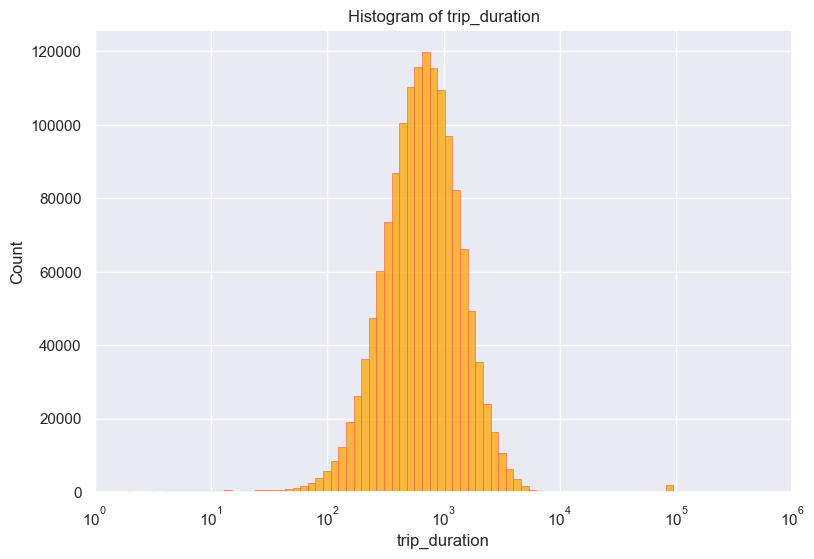

In [6]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_title('Histogram of trip_duration')
sns.histplot(df['trip_duration'],
             bins=100,
             ax=ax, 
             color='orange',
             edgecolor='tomato', log_scale=True)
ax.set_xlim(1, 10**6)
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

<b> Сконцентрированна на значениях от 100 до 10000, но так же есть особые значения меньше 100 и около 100'000, ее логарифм распределен нормально </b>

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

<b> Из гистограммы видно, что логарифм целевой переменной распределен нормально, поэтому с RMSLE будет удобнее работать, если логарифмируем целевую переменную </b>

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: $$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \hat{a}_i\big)^2} = \text{RMSE}(X, \hat{y}, \hat{a})$$

Значит когда мы минимизируем правое выражение, минимизируется левое, и наоборот. Корень - монотонная функция, поэтому мизимизация MSE эквивалентна оптимизации RMSE.

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

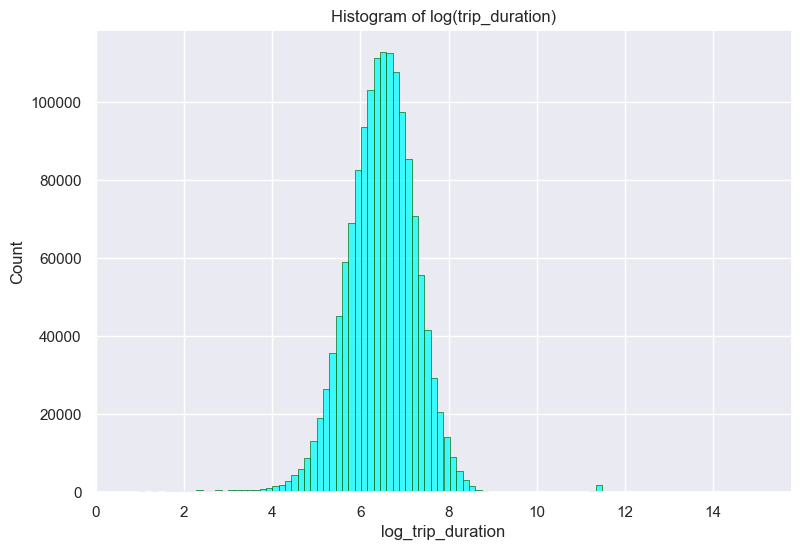

In [7]:
df['log_trip_duration'] = np.log1p(df['trip_duration'])
df = df.drop(columns=['trip_duration'])

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_title('Histogram of log(trip_duration)')
sns.histplot(df['log_trip_duration'],
             bins=100,
             ax=ax,
             color='aqua',
             edgecolor='darkgreen', log_scale=False)

plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [8]:
def rmsle(log1p_y_true, log1p_y_pred):
    return np.sqrt(np.sum(np.square(log1p_y_true - log1p_y_pred)/len(np.square(log1p_y_true - log1p_y_pred))))


l = len(np.array(df['log_trip_duration']))
pred = np.array([np.mean(df['log_trip_duration'])]*l)
rmsle_best_const = rmsle(np.array(df['log_trip_duration']), pred)
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411504


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

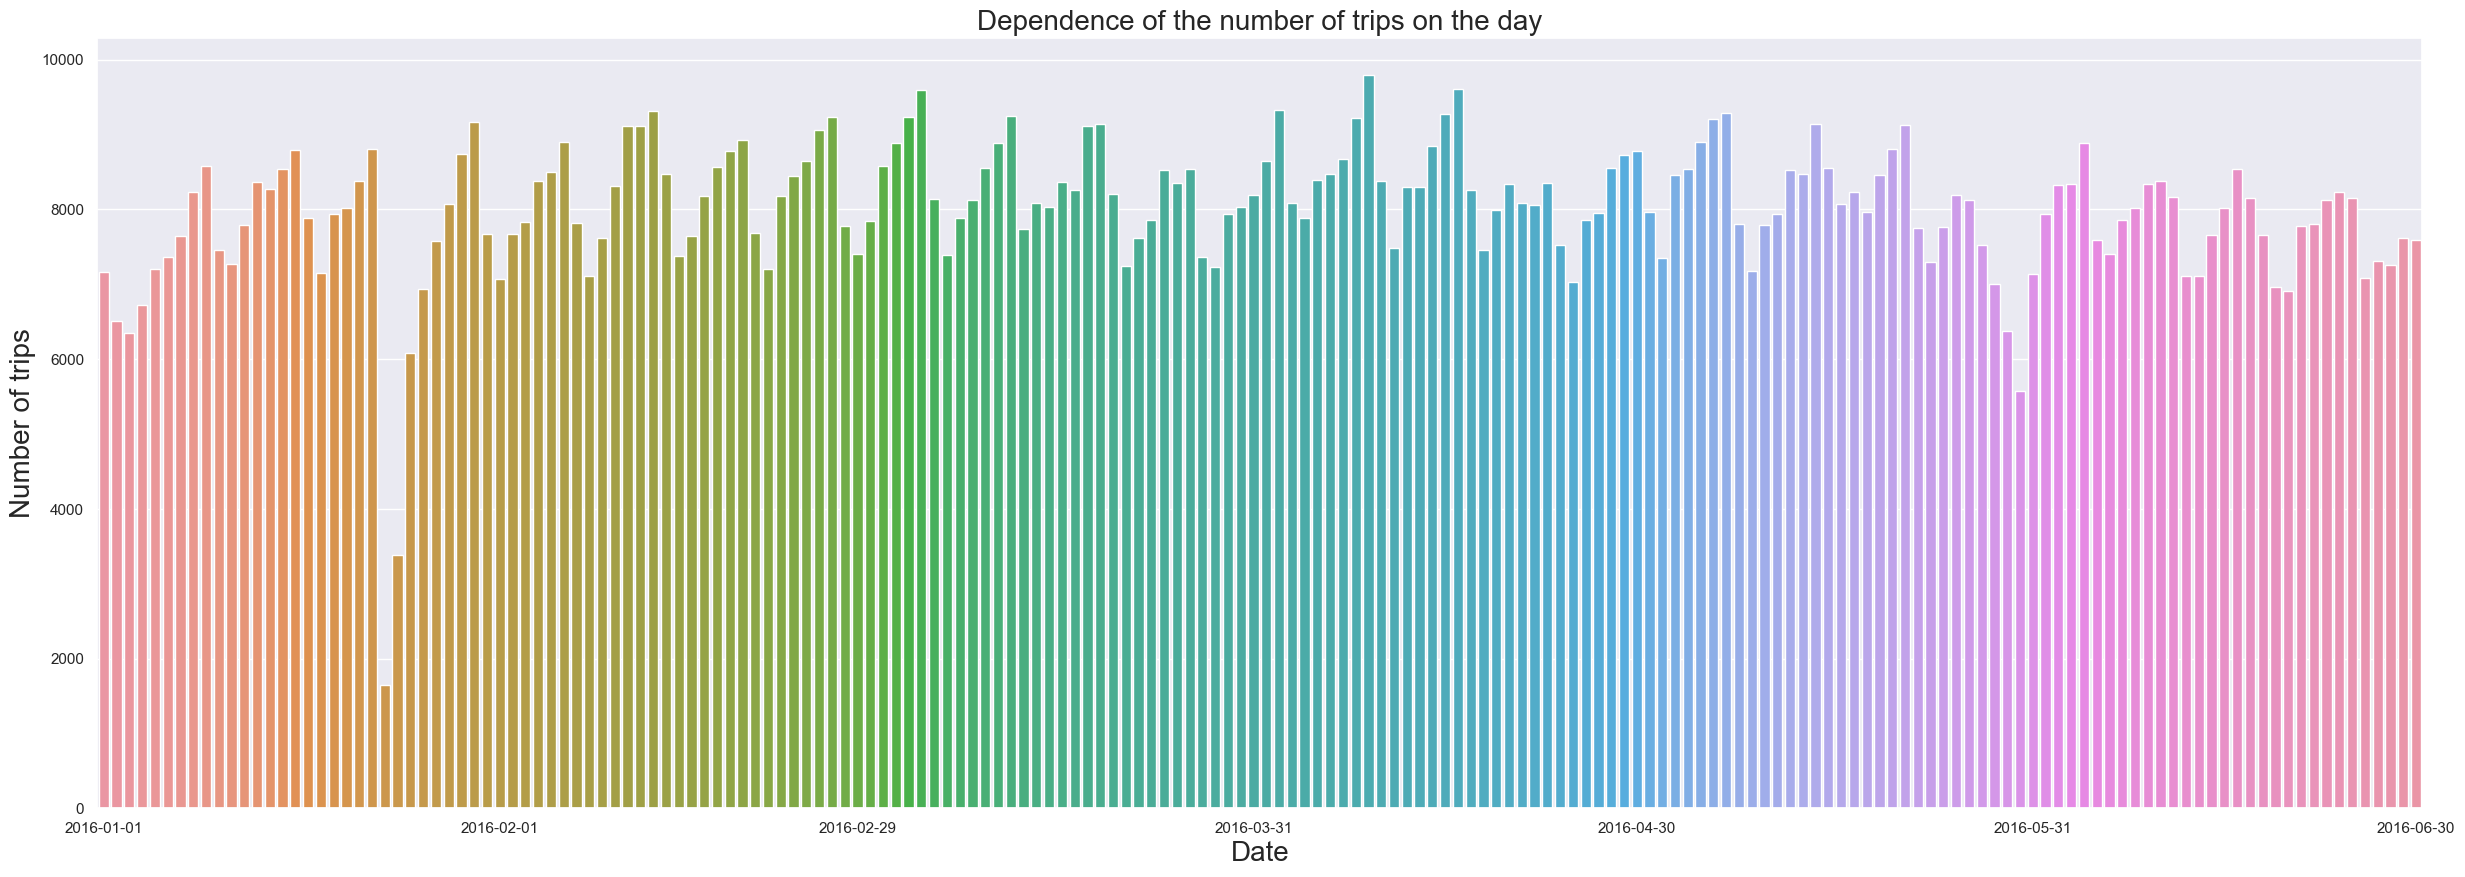

In [9]:
from matplotlib import dates

df = df.sort_values(by=['pickup_datetime'])
df['pickup_date'] = df['pickup_datetime'].dt.date

fig, ax = plt.subplots(figsize=(30, 10))
sns.countplot(data=df, x='pickup_date', ax = ax)

ax.set_title('Dependence of the number of trips on the day', fontsize = 20)
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Number of trips', fontsize = 20)

ax.xaxis.set_major_locator(dates.MonthLocator())

plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [10]:
from datetime import datetime

groupped = df.groupby(df["pickup_date"]).count()
groupped.reset_index(inplace=True)

date_format = '%Y-%m-%d'

abnormal_days_1 = list(groupped[(groupped['id'] < 6000) & (groupped['pickup_date'] < datetime.strptime('2016-02-01', date_format).date())]['pickup_date'])
abnormal_days_2 = list(groupped[(groupped['id'] < 6000) & (groupped['pickup_date'] >= datetime.strptime('2016-02-01', date_format).date())]['pickup_date'])

print('первый период:', *abnormal_days_1, 'Власти запретили автомобильное движение в Нью-Йорке из-за снежной бури')
print('второй период:', *abnormal_days_2, 'Серия нападений со стрельбой')

первый период: 2016-01-23 2016-01-24 Власти запретили автомобильное движение в Нью-Йорке из-за снежной бури
второй период: 2016-05-30 Серия нападений со стрельбой


In [11]:
abmormal_days = []
for el in abnormal_days_1+abnormal_days_2:
    abmormal_days.append(datetime(el.year, el.month, el.day).timetuple().tm_yday)
abmormal_days

[23, 24, 151]

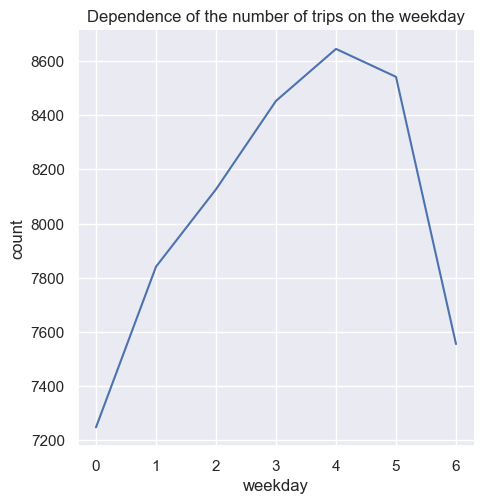

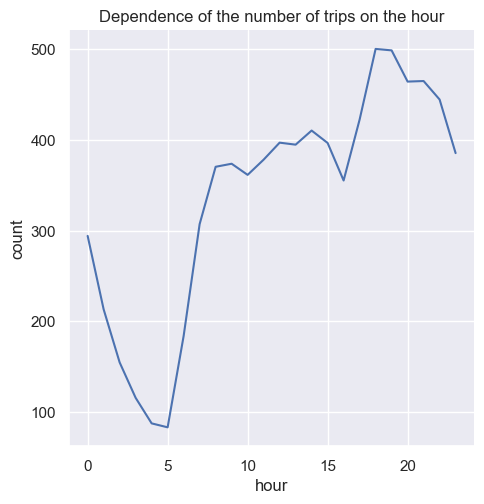

In [12]:
import warnings
warnings.filterwarnings('ignore')

num_of_days = (df['pickup_date'].max() - df['pickup_date'].min()).days

df['pickup_month'] = pd.to_datetime(df['pickup_datetime']).dt.month
df['pickup_weekday'] = pd.to_datetime(df['pickup_datetime']).dt.weekday
df['pickup_day'] = pd.to_datetime(df['pickup_datetime']).dt.dayofyear
df['pickup_hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour

week_plot = sns.relplot(
    data=df.groupby('pickup_weekday').count()/(num_of_days/7), x='pickup_weekday', y='id', kind='line'
).set(title='Dependence of the number of trips on the weekday')

week_plot.set_xlabels('weekday')
week_plot.set_ylabels('count')

hour_plot = sns.relplot(
    data=df.groupby('pickup_hour').count()/(num_of_days), x='pickup_hour', y='id', kind='line'
).set(title='Dependence of the number of trips on the hour')
hour_plot.set_xlabels('hour')
hour_plot.set_ylabels('count')
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

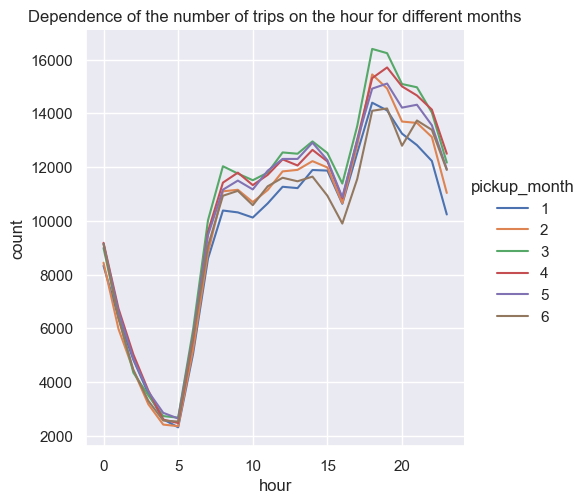

In [13]:
month_hour_plot = sns.relplot(
    data=df.groupby(['pickup_month', 'pickup_hour']).count(), x='pickup_hour', y='id',
    hue='pickup_month', kind='line', palette = sns.color_palette()).set(title = 'Dependence of the number of trips on the hour for different months', xlabel = 'hour', ylabel = 'count')
    
plt.show()

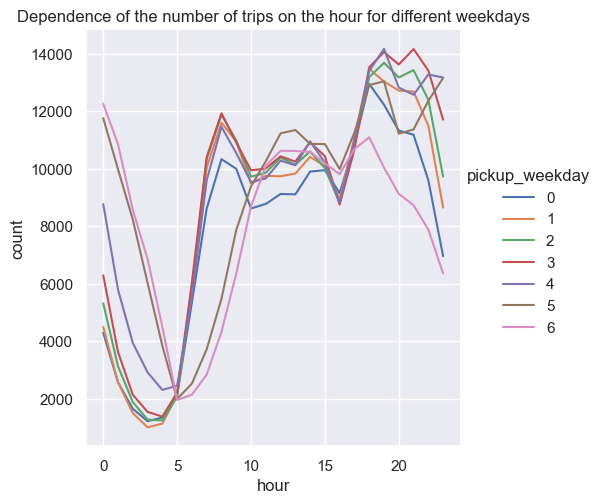

In [14]:
weekday_hour_plot = sns.relplot(
    data=df.groupby(['pickup_weekday', 'pickup_hour']).count(), x='pickup_hour', y='id',
    hue='pickup_weekday', kind='line', palette = sns.color_palette()).set(title = 'Dependence of the number of trips on the hour for different weekdays', xlabel = 'hour', ylabel = 'count')
    
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

По выходным люди реже используют такси (отдыхают дома), ночью очень редко используется такси (спят), пик достигается в 18 часов (едут с работы), по выходным чаще используется такси ночью (люди гуляют до поздна)

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [15]:
from sklearn.model_selection import train_test_split

y = df["log_trip_duration"]

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=7)
X = pd.concat([X_train, X_test])
train_size = X_train.shape[0]

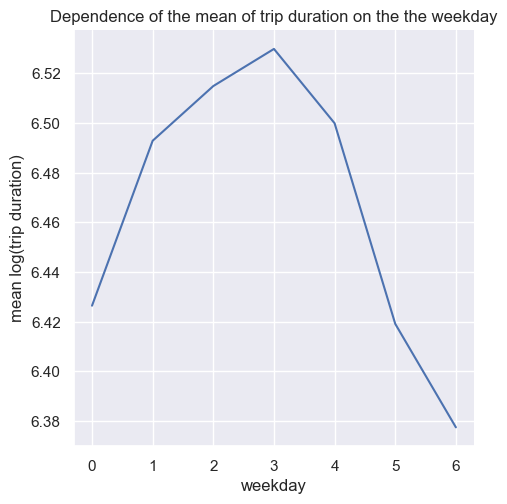

In [16]:
sns.relplot(
    data=X_train.loc[:, ['pickup_weekday', 'log_trip_duration']].groupby(['pickup_weekday']).mean(), x='pickup_weekday', y='log_trip_duration', kind='line', height=5
).set(title = 'Dependence of the mean of trip duration on the the weekday', xlabel = 'weekday', ylabel = 'mean log(trip duration)')
plt.show()

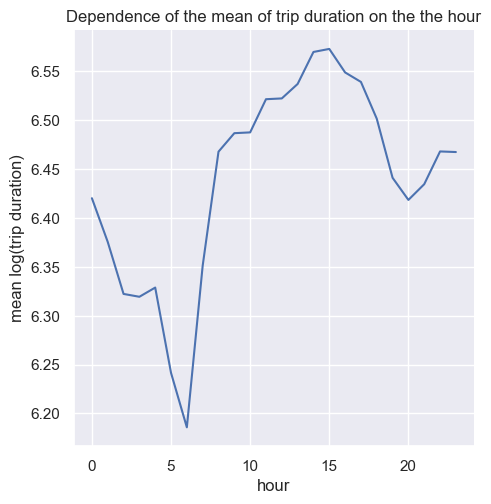

In [17]:
sns.relplot(
    data=X_train.loc[:, ['pickup_hour', 'log_trip_duration']].groupby(['pickup_hour']).mean(), x='pickup_hour', y='log_trip_duration', kind='line', height=5
).set(title = 'Dependence of the mean of trip duration on the the hour', xlabel = 'hour', ylabel = 'mean log(trip duration)')
plt.show()

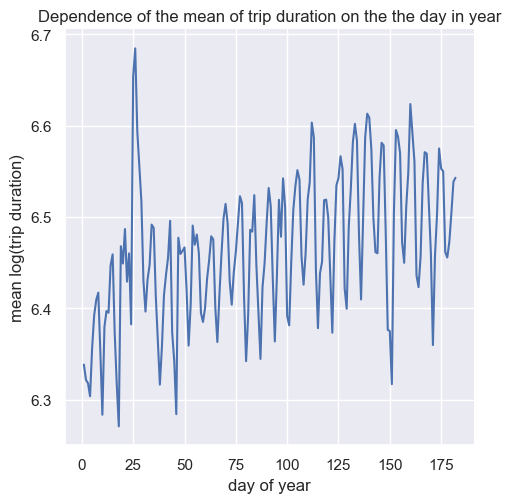

In [18]:
sns.relplot(
    data=X_train.loc[:, ['pickup_day', 'log_trip_duration']].groupby(['pickup_day']).mean(), x='pickup_day', y='log_trip_duration', kind='line', height=5
).set(title = 'Dependence of the mean of trip duration on the the day in year', xlabel = 'day of year', ylabel = 'mean log(trip duration)')
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Графики похожи, возможно потому что, когда число поездок большое, то трафик более загруженый, машины едут медленнее и дольше. В первый аномальный период наблюдаются большие значения целевой переменной(дороги перекрыли, поэтому добираться стало сложнее и дольше), во второй период наоборот значения снижаются(так как люди сидят дома). На графике зависимости целевой переменной от дня в году наблюдается тренд роста.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [19]:
X['is_abnormal_1'] = 0
X['is_abnormal_2'] = 0
for day in abnormal_days_1:
    X.loc[day == X['pickup_date'], 'is_abnormal_1'] = 1

for day in abnormal_days_2:
    X.loc[day == X['pickup_date'], 'is_abnormal_2'] = 1

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

Категориальные:
- является аномальным;
- день недели;
- месяц;
- час.

Числовые:
- день в году.

Так, потому что от дня в году есть монотонная зависимость(если убрать шум), а остальные признаки нельзя упорядочить(нет линейной зависимости с признаком, поэтому нужна бинаризация)

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [20]:
categorical = ['pickup_weekday', 'is_abnormal_1', 'is_abnormal_2', 'pickup_month', 'pickup_hour']
numeric = ['pickup_day']
features = categorical + numeric

In [21]:
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.7891


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [23]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [24]:
# show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")  #чтобы не мешало

In [25]:
# show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

Аэропорт "John Kennedy", аэропорт "LaGuardia", могут быть полезны, так как добираться до/от может быть придется по другим дорогам, где другой темп, другое устройство дорог. Они могут помочь учесть и такие маршруты.

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [26]:
from numpy import cos, sin, arcsin, sqrt

#https://stackoverflow.com/questions/25767596/vectorised-haversine-formula-with-a-pandas-dataframe
def vectorized_haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    dlat = lat2 - lat1 
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a)) 
    km = 6378 * c
    return km

In [27]:
X.loc[:, 'haversine'] = vectorized_haversine(lon1 = X['pickup_longitude'], lat1 = X['pickup_latitude'], lon2 = X['dropoff_longitude'], lat2 = X['dropoff_latitude'])

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [28]:
X['log_haversine'] = np.log1p(X['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [29]:
your_df = X
assert your_df['log_haversine'].corr(your_df['log_trip_duration']) > your_df['haversine'].corr(your_df['log_trip_duration'])

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

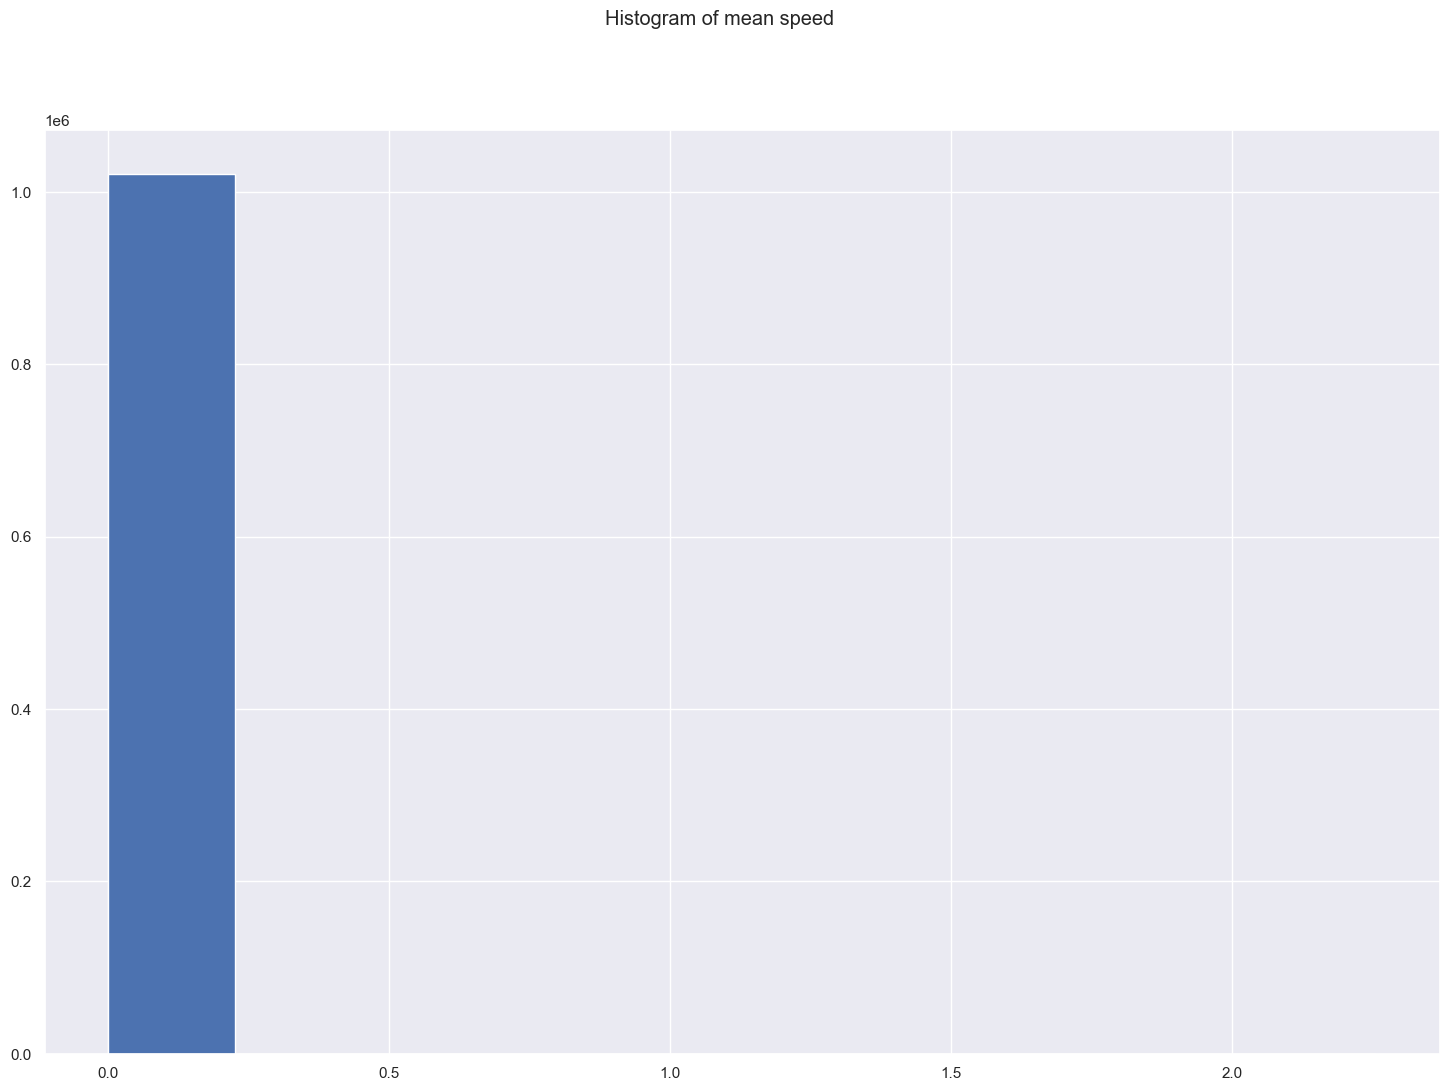

In [30]:
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
X_train['speed'] = X_train['haversine']/np.exp(X_train['log_trip_duration'])
X_train['speed'].hist()
plt.suptitle("Histogram of mean speed")
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

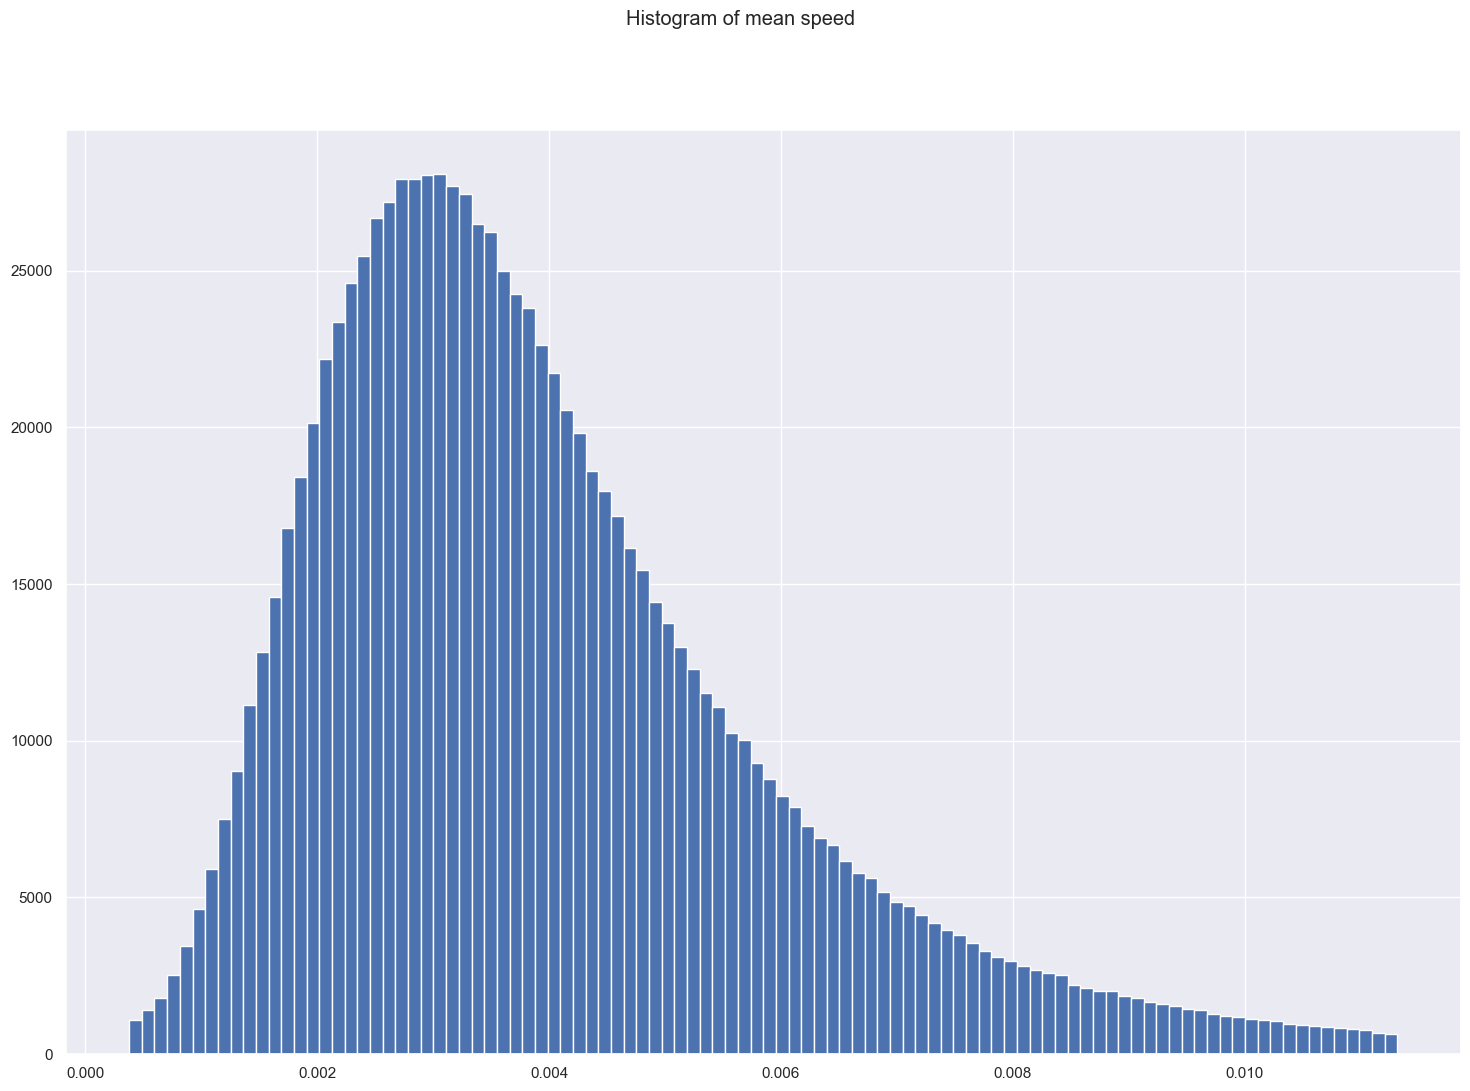

In [31]:
X_train[(X_train['speed']<X_train['speed'].quantile(0.99)) & (X_train['speed']>X_train['speed'].quantile(0.01))]['speed'].hist(bins = 100)
plt.suptitle("Histogram of mean speed")
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

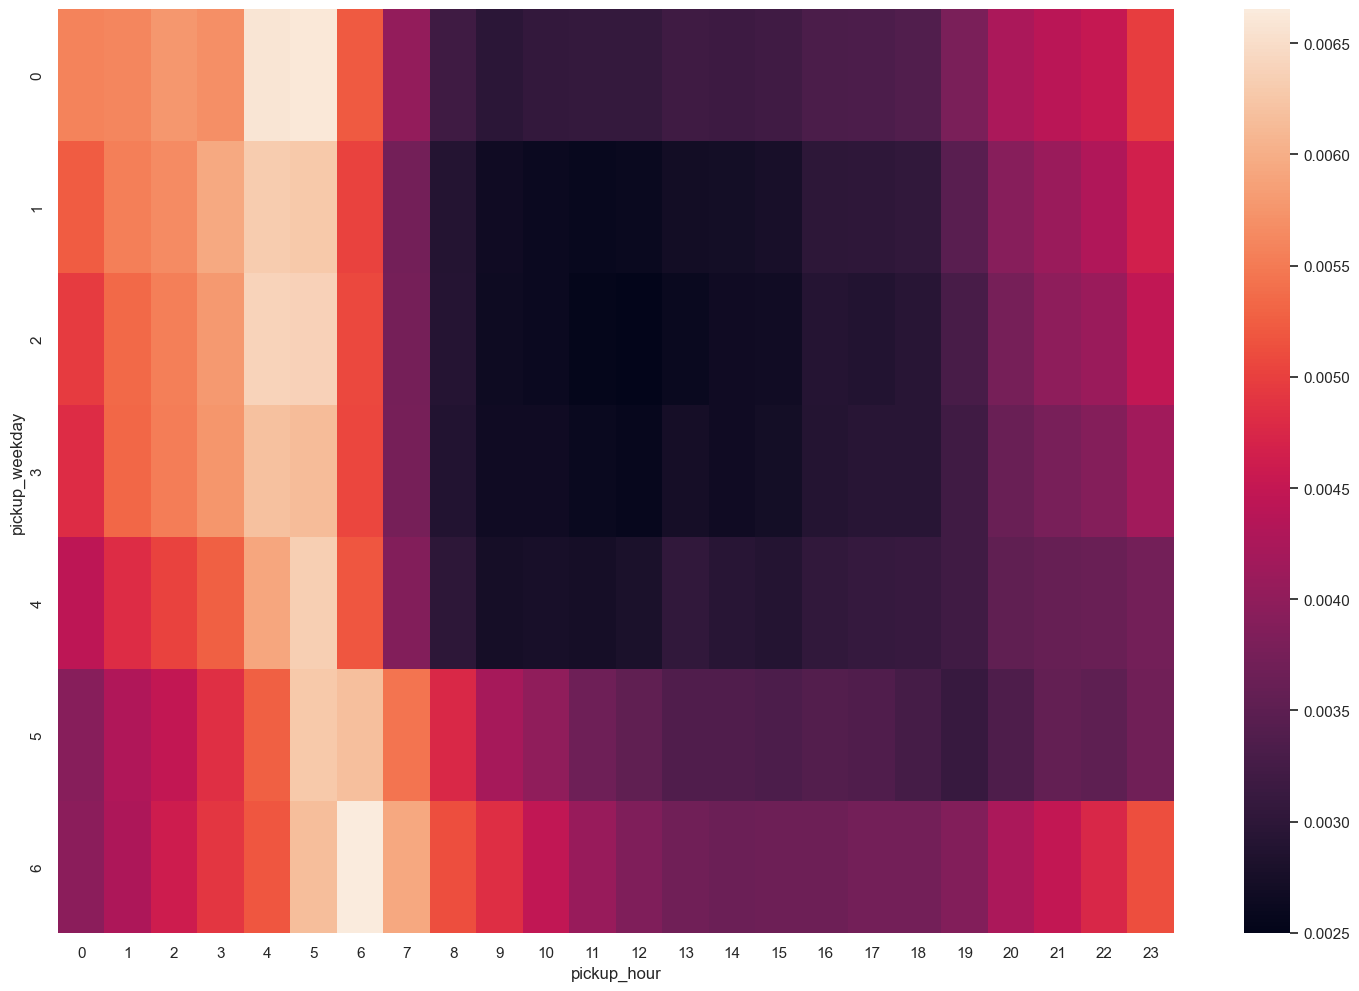

In [32]:
groupped = X_train[['speed', 'pickup_weekday', 'pickup_hour']].groupby(['pickup_weekday', 'pickup_hour']).median()
groupped.reset_index(inplace=True)
groupped = groupped.pivot(index = "pickup_weekday", columns = "pickup_hour", values = "speed")
sns.heatmap(groupped)
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [33]:
X_train = X_train.drop(columns=['speed'])

потому что в тестовой выборке у нас не получится сделать такой признак

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [34]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X['in_jam'] = 0
X['in_free'] = 0

cond1 = X['pickup_weekday'] < 5
cond2 = X['pickup_hour'] < 13
cond3 = X['pickup_hour'] > 8
cond4 = X['pickup_weekday'] > 0

X.loc[cond1 & cond2 & cond3 & cond4, 'in_jam'] = 1


cond1 = X['pickup_weekday'] < 4
cond2 = X['pickup_hour'] > 12
cond3 = X['pickup_hour'] < 16
cond4 = X['pickup_weekday'] > 0

X.loc[cond1 & cond2 & cond3 & cond4, 'in_jam'] = 1

X.loc[(X['pickup_weekday'] == 4) & (X['pickup_hour'] == 15), 'in_jam'] = 1
X.loc[(X['pickup_weekday'] == 5) & (X['pickup_hour'] == 19), 'in_jam'] = 1
X.loc[(X['pickup_weekday'] == 3) & (X['pickup_hour'] == 18), 'in_jam'] = 1


cond1 = X['pickup_weekday'] >= 0
cond2 = X['pickup_hour'] > 3
cond3 = X['pickup_hour'] < 6
cond4 = X['pickup_weekday'] < 4

X.loc[cond1 & cond2 & cond3 & cond4, 'in_free'] = 1

cond1 = X['pickup_weekday'] > 4
cond2 = X['pickup_hour'] > 4
cond3 = X['pickup_hour'] < 7
cond4 = X['pickup_weekday'] < 7

X.loc[cond1 & cond2 & cond3 & cond4, 'in_free'] = 1

X.loc[(X['pickup_weekday'] == 4) & (X['pickup_hour'] == 5), 'in_free'] = 1

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака: 
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

In [35]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
LaGuardia_airport = (40.7769271, -73.87396)
Kennedy_airport = (40.641766, -73.780968)

X['from_LaGuardia'] = 0
X['to_LaGuardia'] = 0

X['from_Kennedy'] = 0
X['to_Kennedy'] = 0

In [36]:
def check_near(lat1, lon1, lat2, lon2):
    return vectorized_haversine(lat1, lon1, lat2, lon2)  < 1

In [37]:
X['from_LaGuardia'] = check_near(lat1 = LaGuardia_airport[0], lon1 = LaGuardia_airport[1], lat2=X['pickup_latitude'], lon2=X['pickup_longitude'])
X['to_LaGuardia'] = check_near(lat1 = LaGuardia_airport[0], lon1 = LaGuardia_airport[1], lat2=X['dropoff_latitude'], lon2=X['dropoff_longitude'])
X['from_Kennedy'] = check_near(lat1 = Kennedy_airport[0], lon1 = Kennedy_airport[1], lat2=X['pickup_latitude'], lon2=X['pickup_longitude'])
X['to_Kennedy'] = check_near(lat1 = Kennedy_airport[0], lon1 = Kennedy_airport[1], lat2=X['dropoff_latitude'], lon2=X['dropoff_longitude'])

Могут быть полезны, чтобы учесть редкие объекты в датасете

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

In [38]:
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

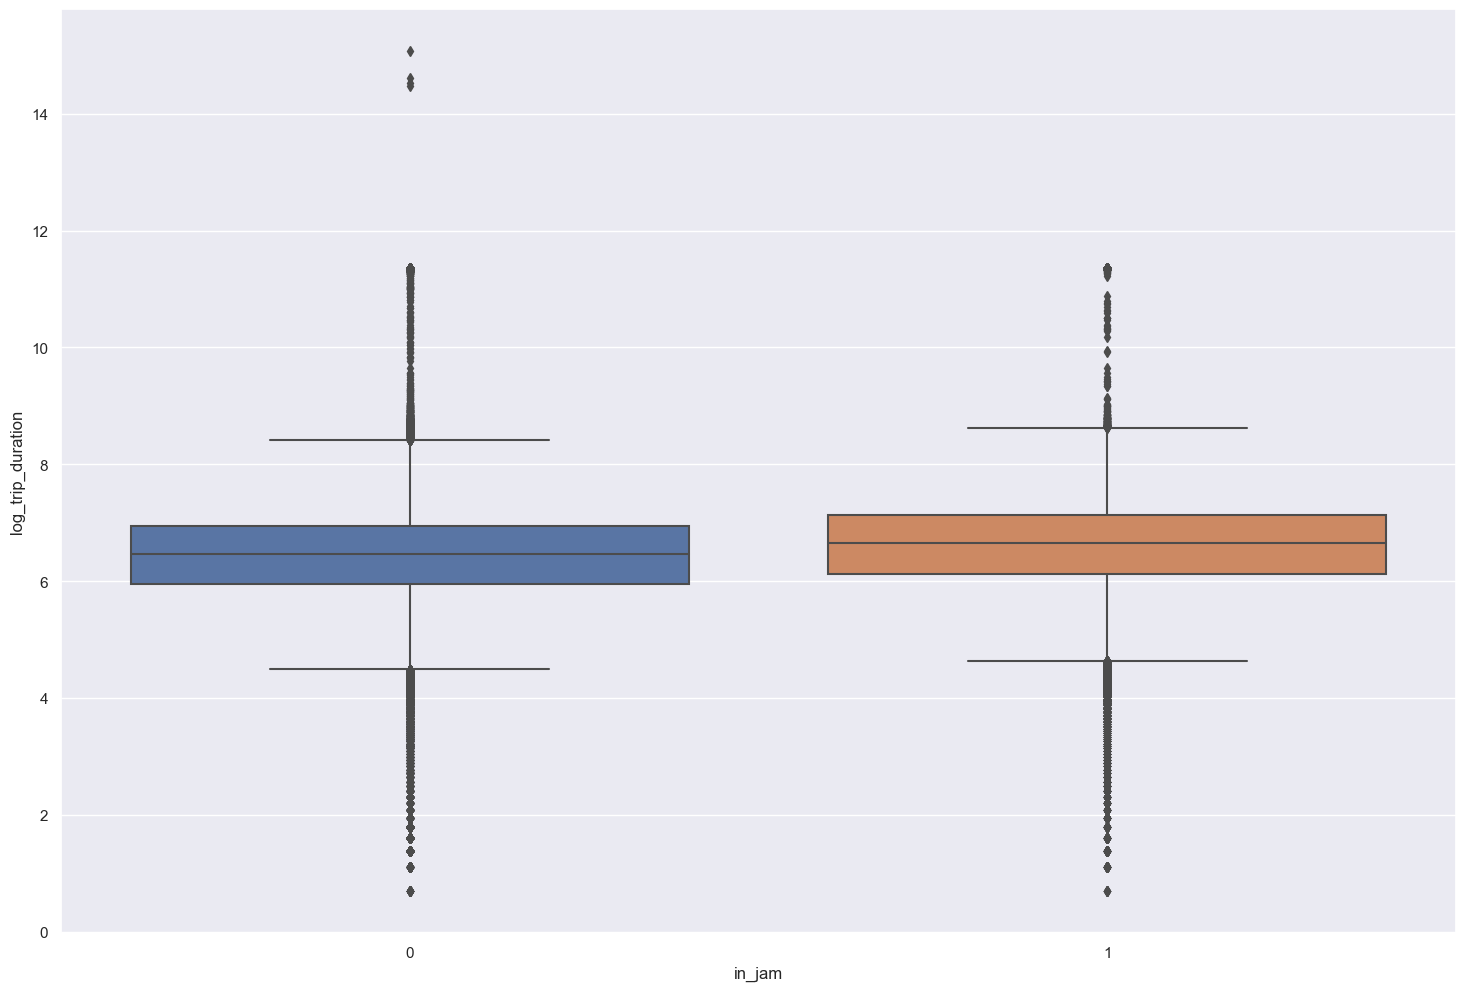

In [39]:
sns.boxplot(data = X_train, y='log_trip_duration', x='in_jam')
plt.show()

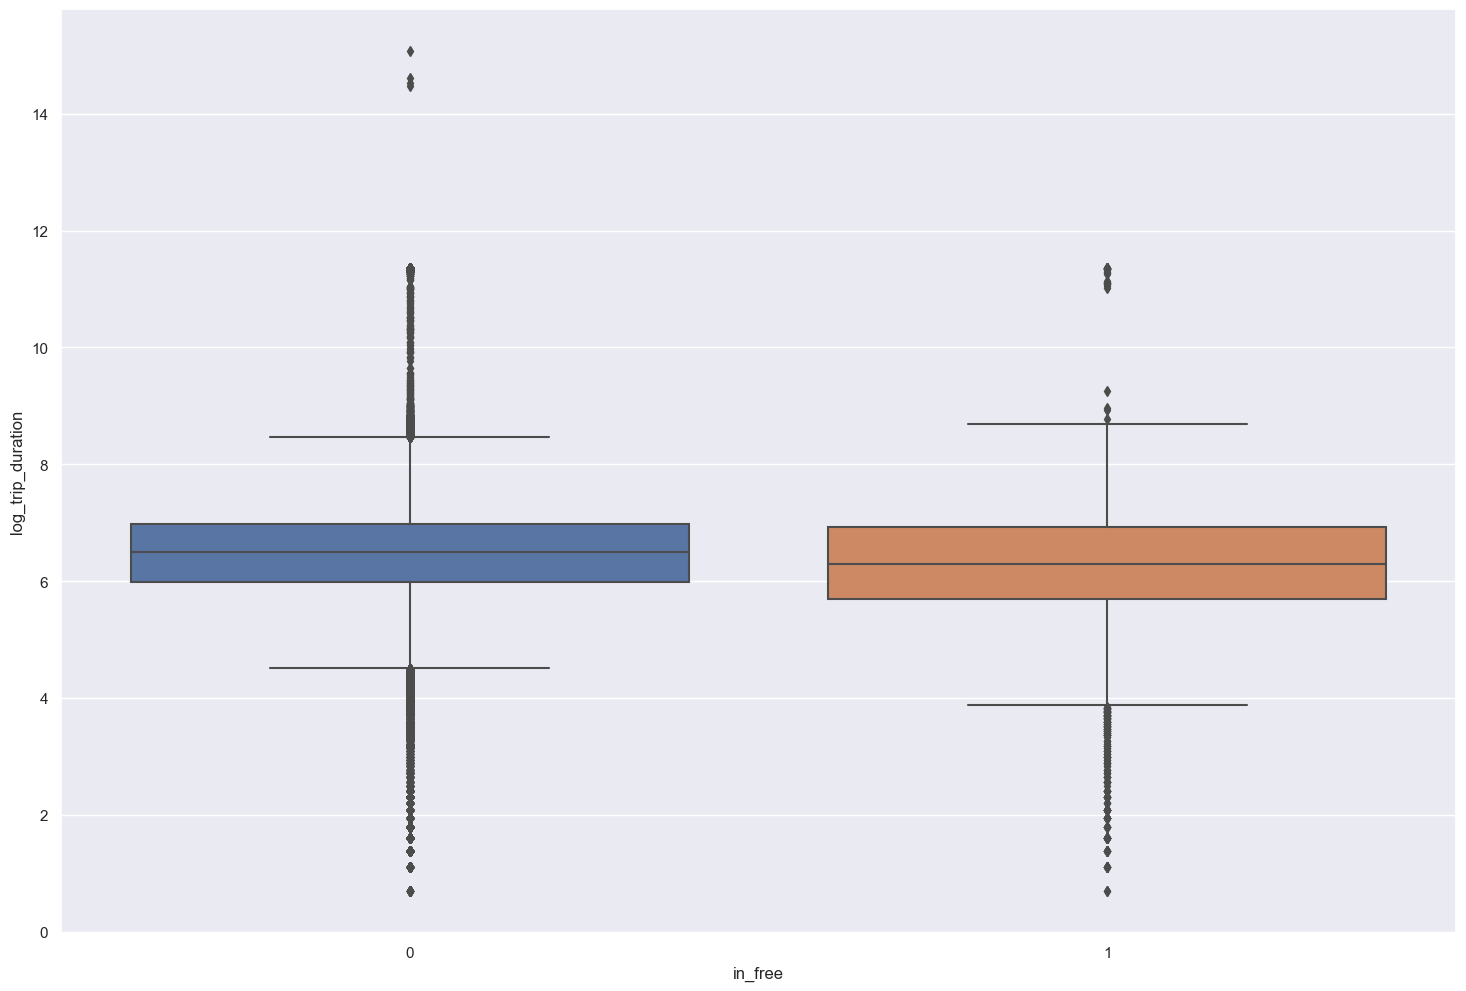

In [40]:
sns.boxplot(data = X_train, y='log_trip_duration', x='in_free')
plt.show()

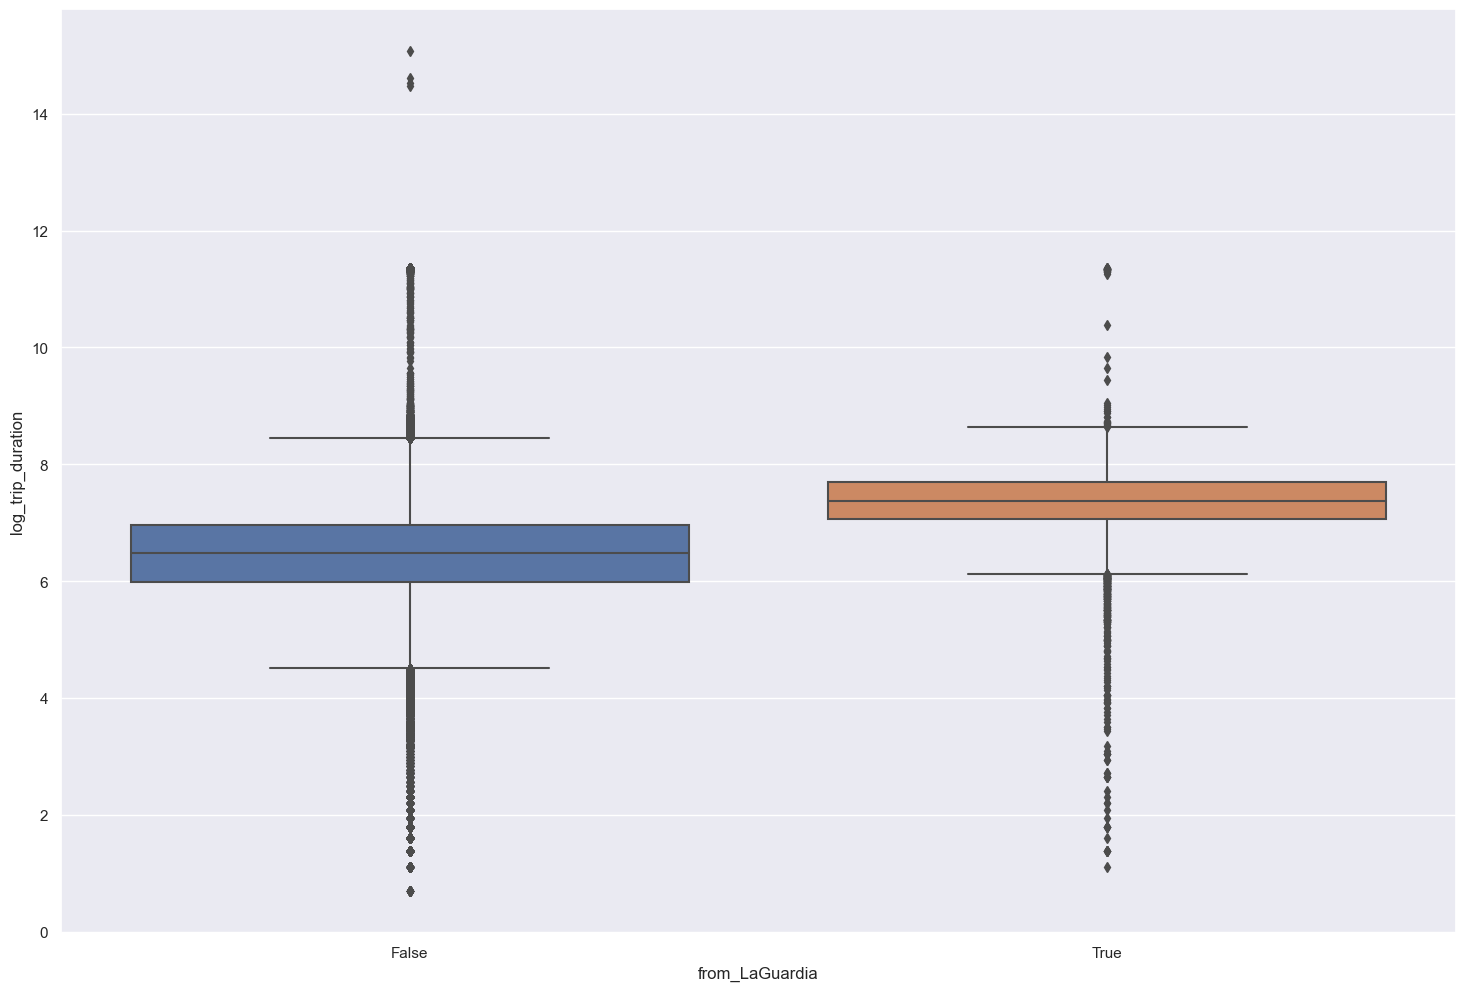

In [41]:
sns.boxplot(data = X_train, y='log_trip_duration', x='from_LaGuardia')
plt.show()

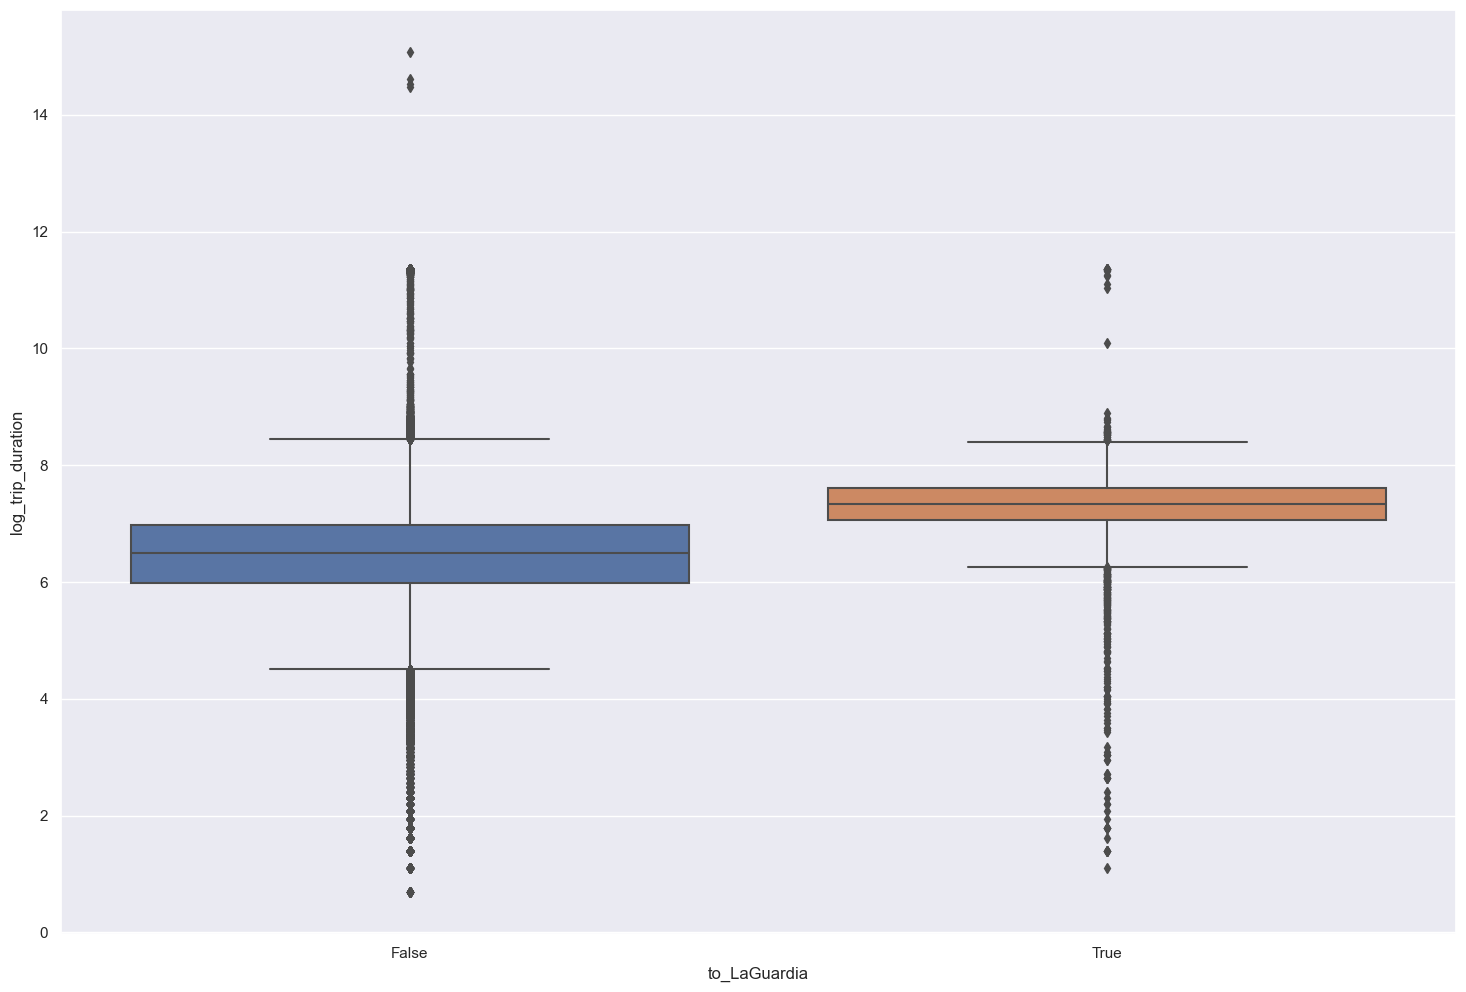

In [42]:
sns.boxplot(data = X_train, y='log_trip_duration', x='to_LaGuardia')
plt.show()

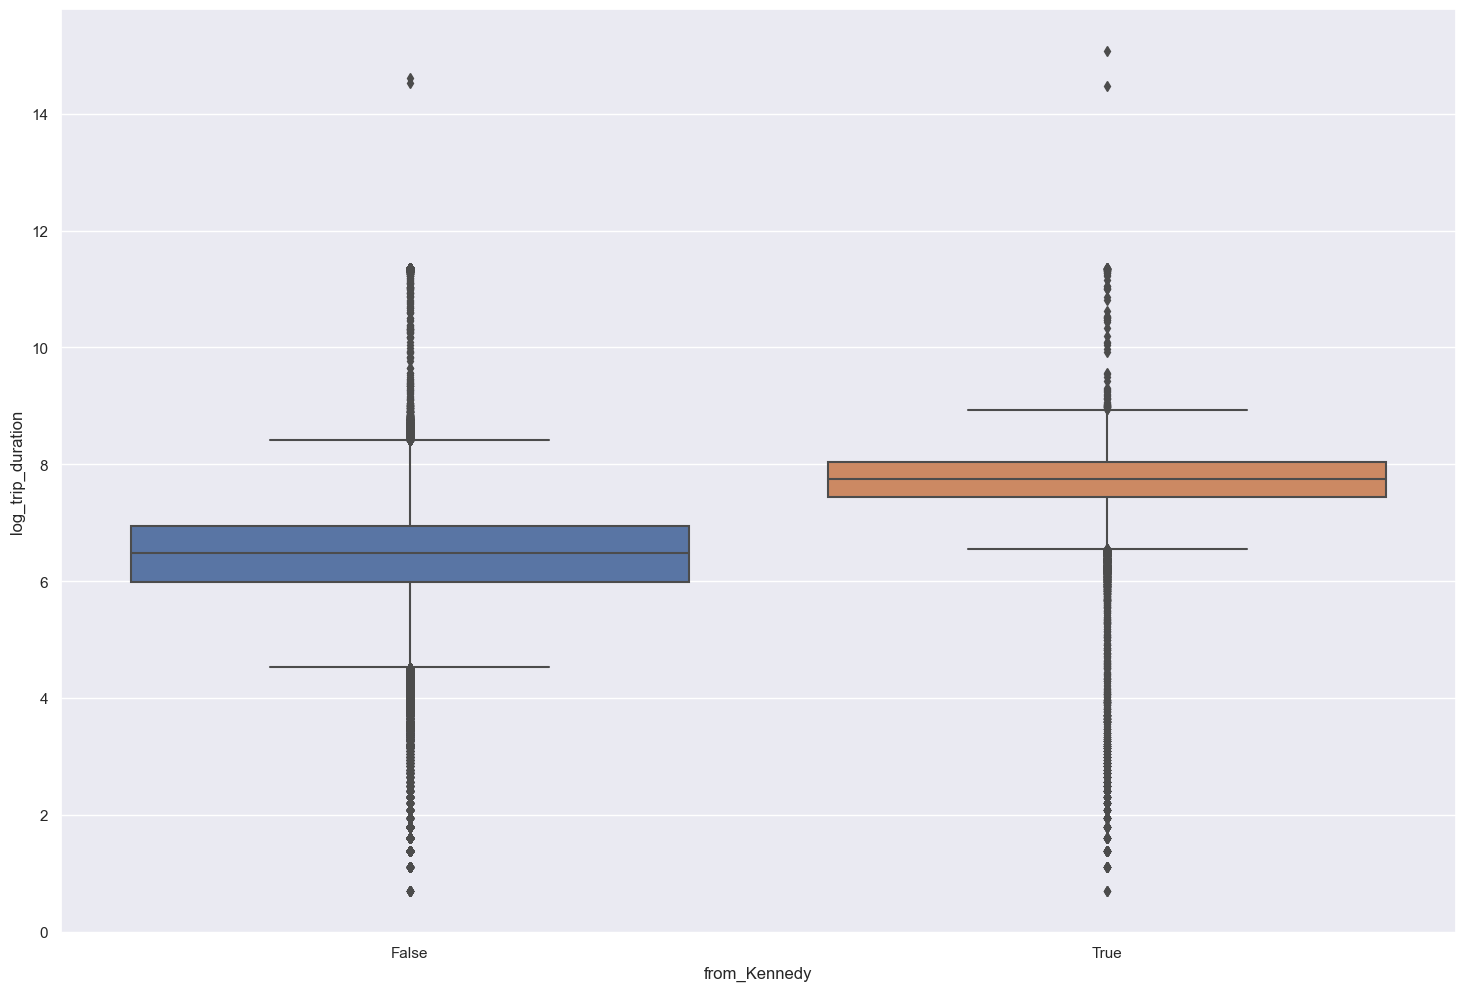

In [43]:
sns.boxplot(data = X_train, y='log_trip_duration', x='from_Kennedy')
plt.show()

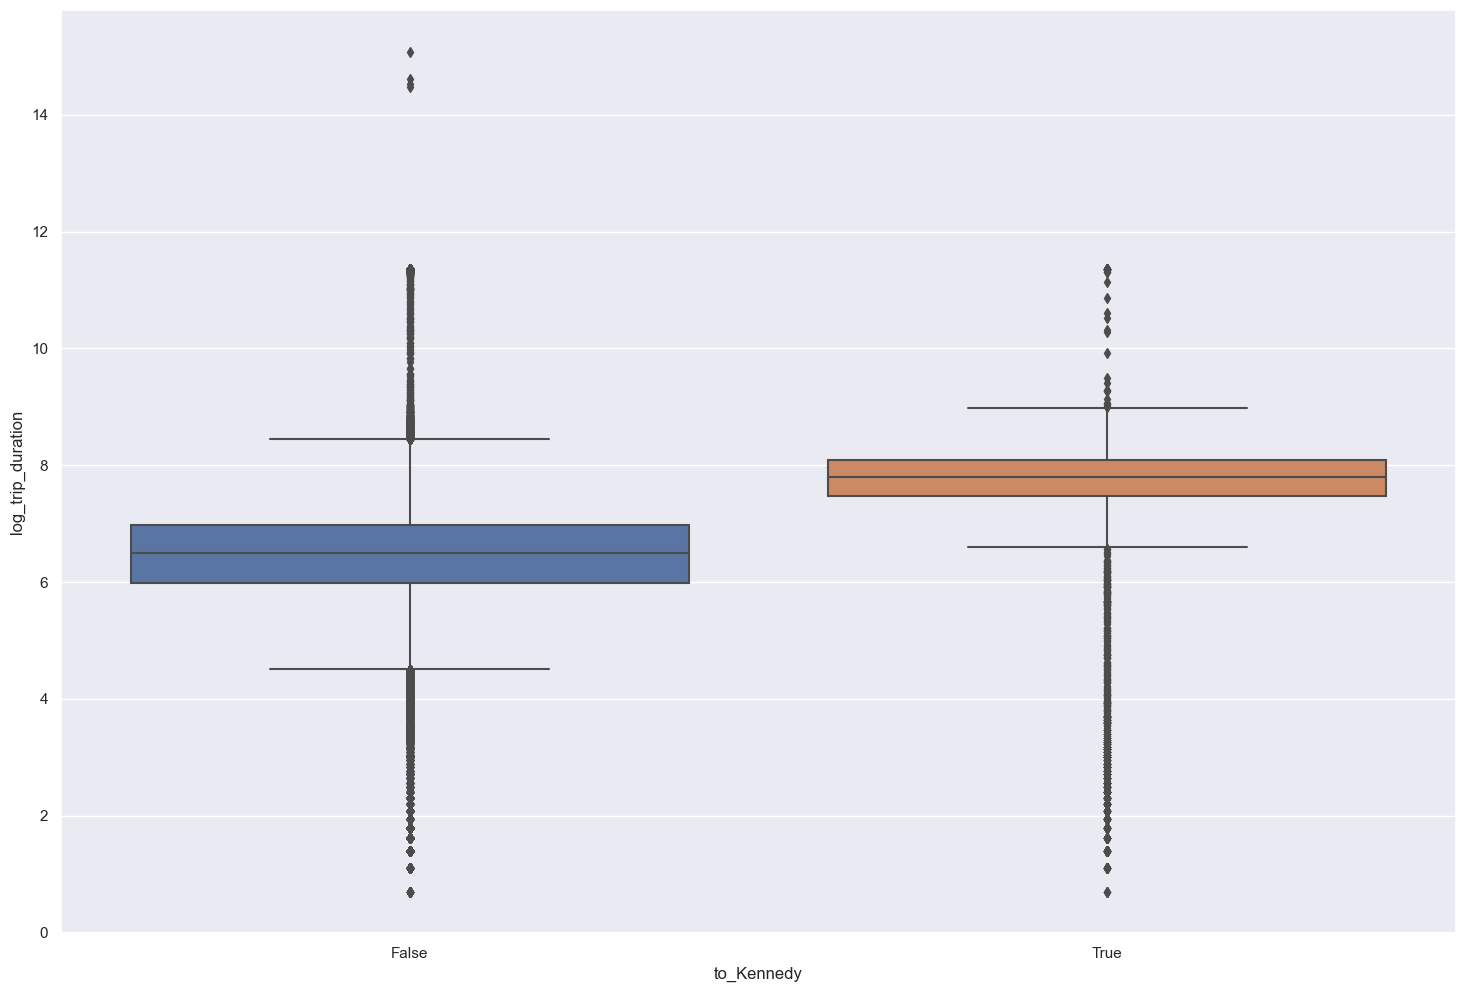

In [44]:
sns.boxplot(data = X_train, y='log_trip_duration', x='to_Kennedy')
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

Да, в пробках значение целевой переменной в среднем больше, а при свободных дорогах меньше. Так же дисперсии распределений разные, значит такие данные распределены по разному, их следует отличать.

При движении в аэропорт, с аэропорта - время движение в среднем больше, при этом дисперсия распределения целевой переменной меньше

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin
    
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rows_cnt = None, columns_cnt = None):
        self.rows_cnt = rows_cnt
        self.columns_cnt = columns_cnt
        self.min_latitude = None
        self.max_latitude = None
        self.min_longitude = None
        self.max_longitude = None
        self.height = None
        self.width = None
    
    def show_map(self):
        location = ((self.min_latitude+self.max_latitude)/2, (self.min_longitude+self.max_longitude)/2)
        m = folium.Map(location=location)


        for row in range(self.rows_cnt):
            for column in range(self.columns_cnt):
                folium.Rectangle([(self.max_latitude - self.height*(row+1), self.min_longitude + self.width*column), (self.max_latitude - self.height*(row), self.min_longitude + self.width*(column+1))],
                color="green",
                weight=2,
                fill=True,
                fill_color="pink",
                fill_opacity=0.5).add_to(m)
        return m
    
    def fit(self, X=None, y=None):
        if X is not None:
            self.min_latitude = min(X['pickup_latitude'].quantile(0.01), X['dropoff_latitude'].quantile(0.01))
            self.max_latitude = max(X['pickup_latitude'].quantile(0.99), X['dropoff_latitude'].quantile(0.99))
            self.min_longitude = min(X['pickup_longitude'].quantile(0.01), X['dropoff_longitude'].quantile(0.01))
            self.max_longitude = max(X['pickup_longitude'].quantile(0.99), X['dropoff_longitude'].quantile(0.99))
            self.height = (self.max_latitude - self.min_latitude)/self.rows_cnt
            self.width = (self.max_longitude - self.min_longitude)/self.columns_cnt
        return self

    def transform(self, X, y=None):
        copy = X.copy()
        copy['pick_cell'] = -1
        copy['drop_cell'] = -1

        pick_cond1 = (copy['pickup_latitude']>self.min_latitude) & (copy['pickup_latitude']<self.max_latitude)
        pick_cond2 = (copy['pickup_longitude']>self.min_longitude) & (copy['pickup_longitude']<self.max_longitude)

        drop_cond1 = (copy['dropoff_latitude']>self.min_latitude) & (copy['dropoff_latitude']<self.max_latitude)
        drop_cond2 = (copy['dropoff_longitude']>self.min_longitude) & (copy['dropoff_longitude']<self.max_longitude)

        copy.loc[pick_cond1 & pick_cond2, 'pick_cell'] = (copy['pickup_longitude'] - self.min_longitude)//self.width + ((copy['pickup_latitude'] - self.min_latitude)//self.height)*self.columns_cnt
        copy.loc[drop_cond1 & drop_cond2, 'drop_cell'] = (copy['dropoff_longitude'] - self.min_longitude)//self.width + ((copy['dropoff_latitude'] - self.min_latitude)//self.height)*self.columns_cnt

        return copy

In [46]:
rows, cols = 20, 20
MGT = MapGridTransformer(rows, cols)
MGT.fit(X)
X = MGT.transform(X)
MGT.show_map()

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [47]:
categorical.extend(['in_jam', 'in_free', 'from_LaGuardia', 'to_LaGuardia', 'from_Kennedy', 'to_Kennedy', 'pick_cell', 'drop_cell'])
numeric.extend(['haversine', 'log_haversine'])
features = categorical + numeric

In [48]:
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

In [49]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4673


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [50]:
print('Число различных vendor_id:', X_train['vendor_id'].nunique())
print('Число различных passenger_count:', X_train['passenger_count'].nunique())
print('Число различных store_and_fwd_flag:', X_train['store_and_fwd_flag'].nunique())

Число различных vendor_id: 2
Число различных passenger_count: 8
Число различных store_and_fwd_flag: 2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

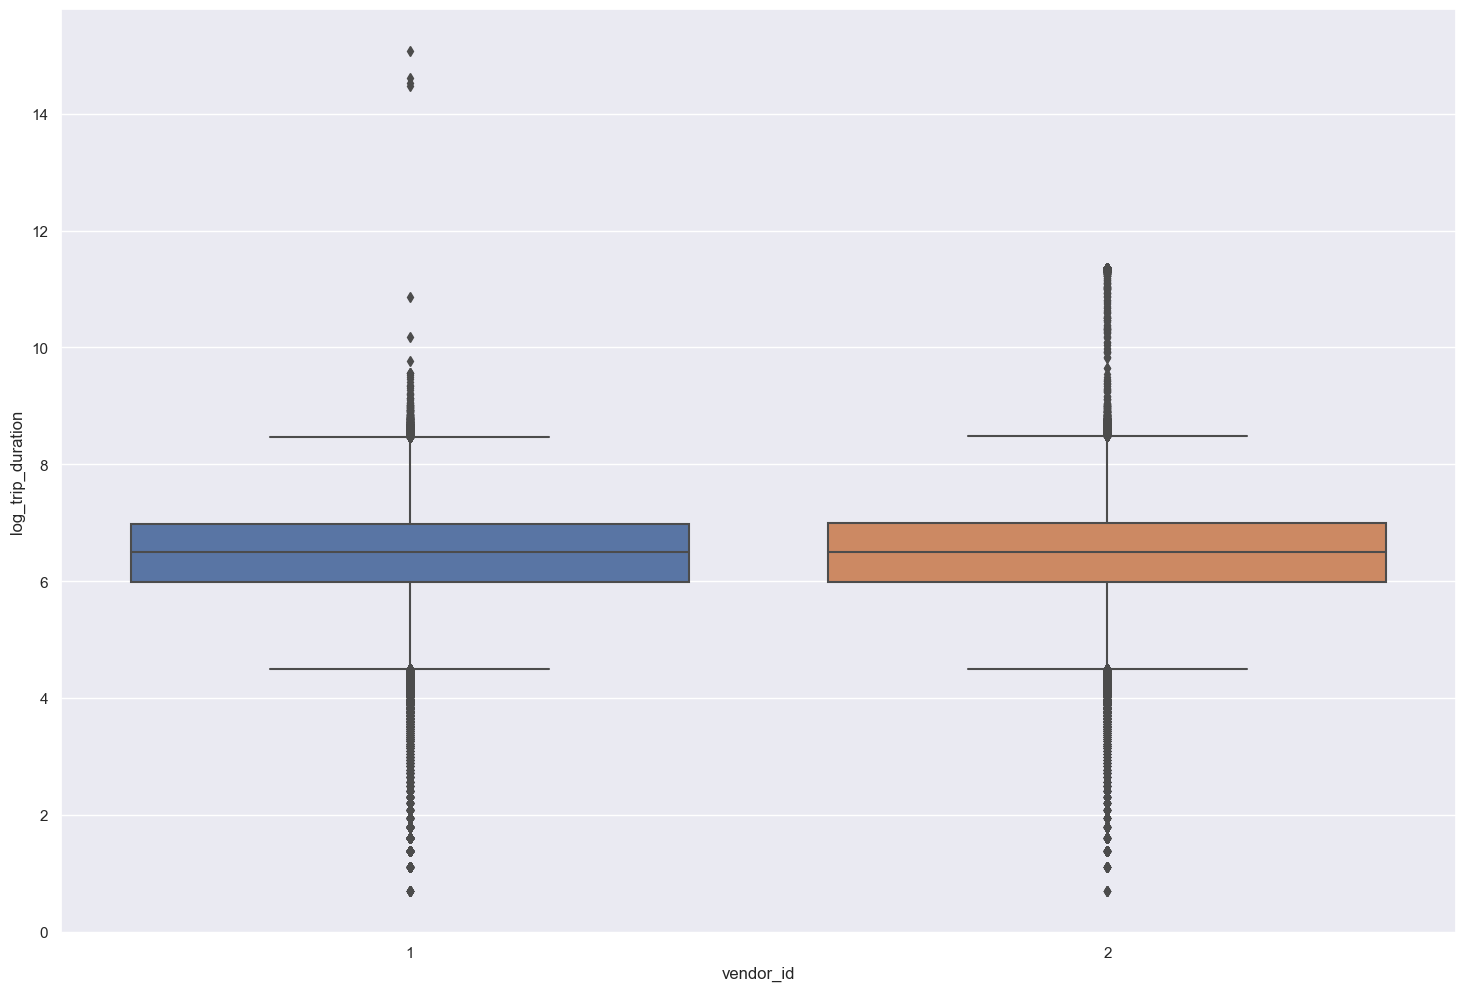

In [51]:
sns.boxplot(data = X_train, y='log_trip_duration', x='vendor_id')
plt.show()

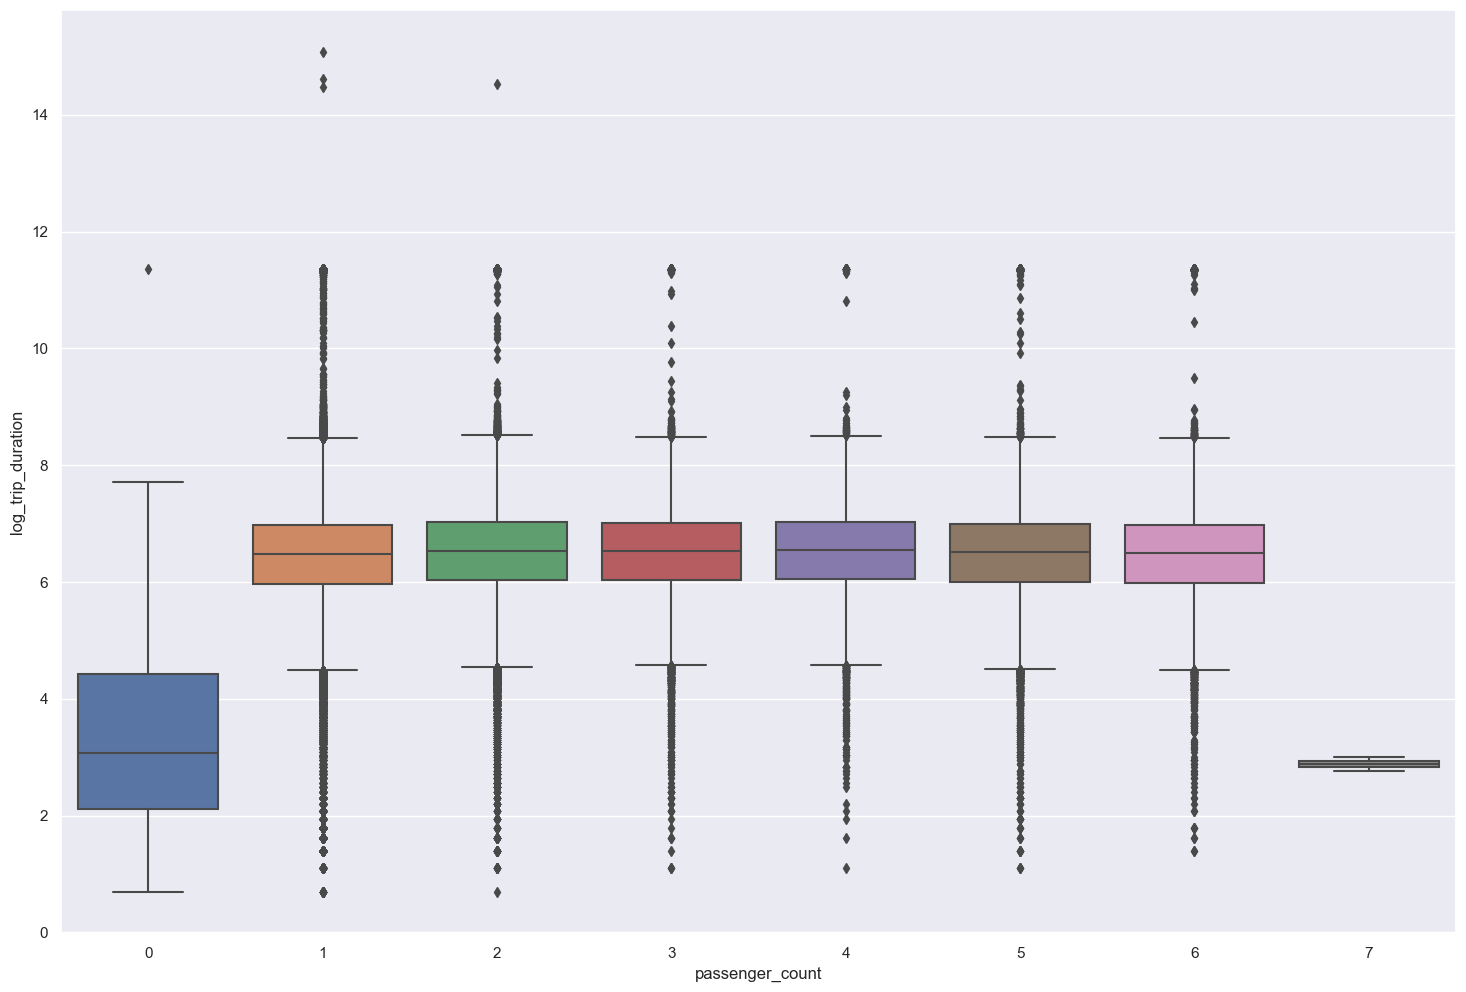

In [52]:
sns.boxplot(data = X_train, y='log_trip_duration', x='passenger_count')
plt.show()

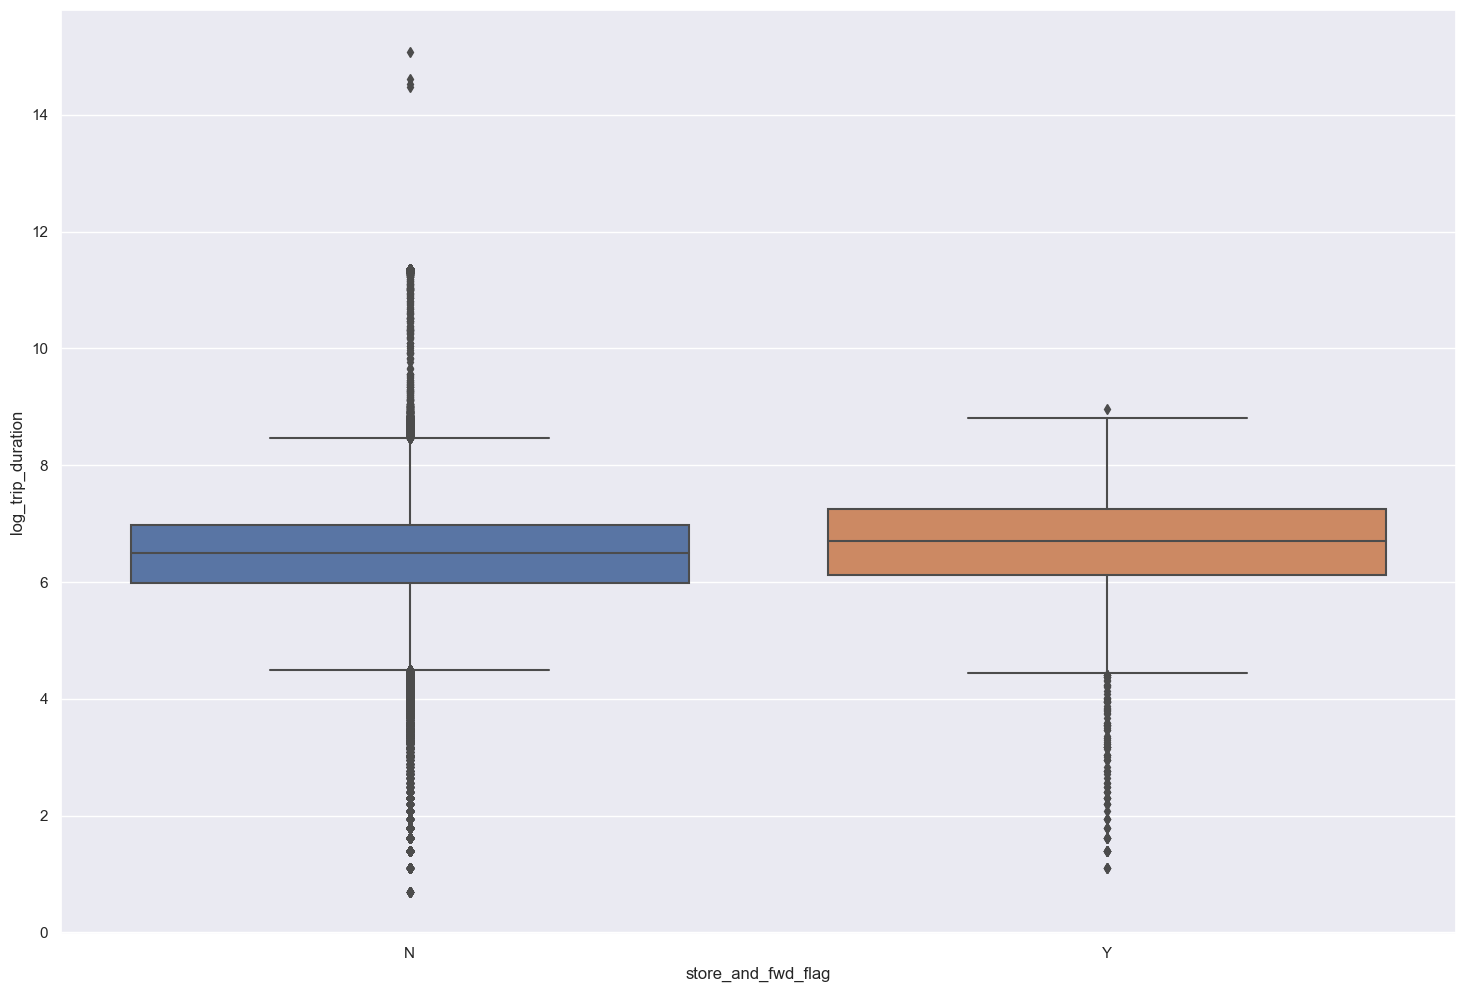

In [53]:
sns.boxplot(data = X_train, y='log_trip_duration', x='store_and_fwd_flag')
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [54]:
X['store_and_fwd_flag'] = 1*(X['store_and_fwd_flag']=='Y')
X['vendor_id']-=1

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Ящики с усами не сильно отличаются при разных значениях признака, поэтому признаки кажется не будут сильными

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [55]:
categorical.extend(['vendor_id', 'store_and_fwd_flag', 'passenger_count'])
features = categorical+numeric

In [56]:
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4668


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

In [57]:
# выбросим их
categorical.remove('vendor_id')
categorical.remove('store_and_fwd_flag')
categorical.remove('passenger_count')
features = categorical+numeric

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

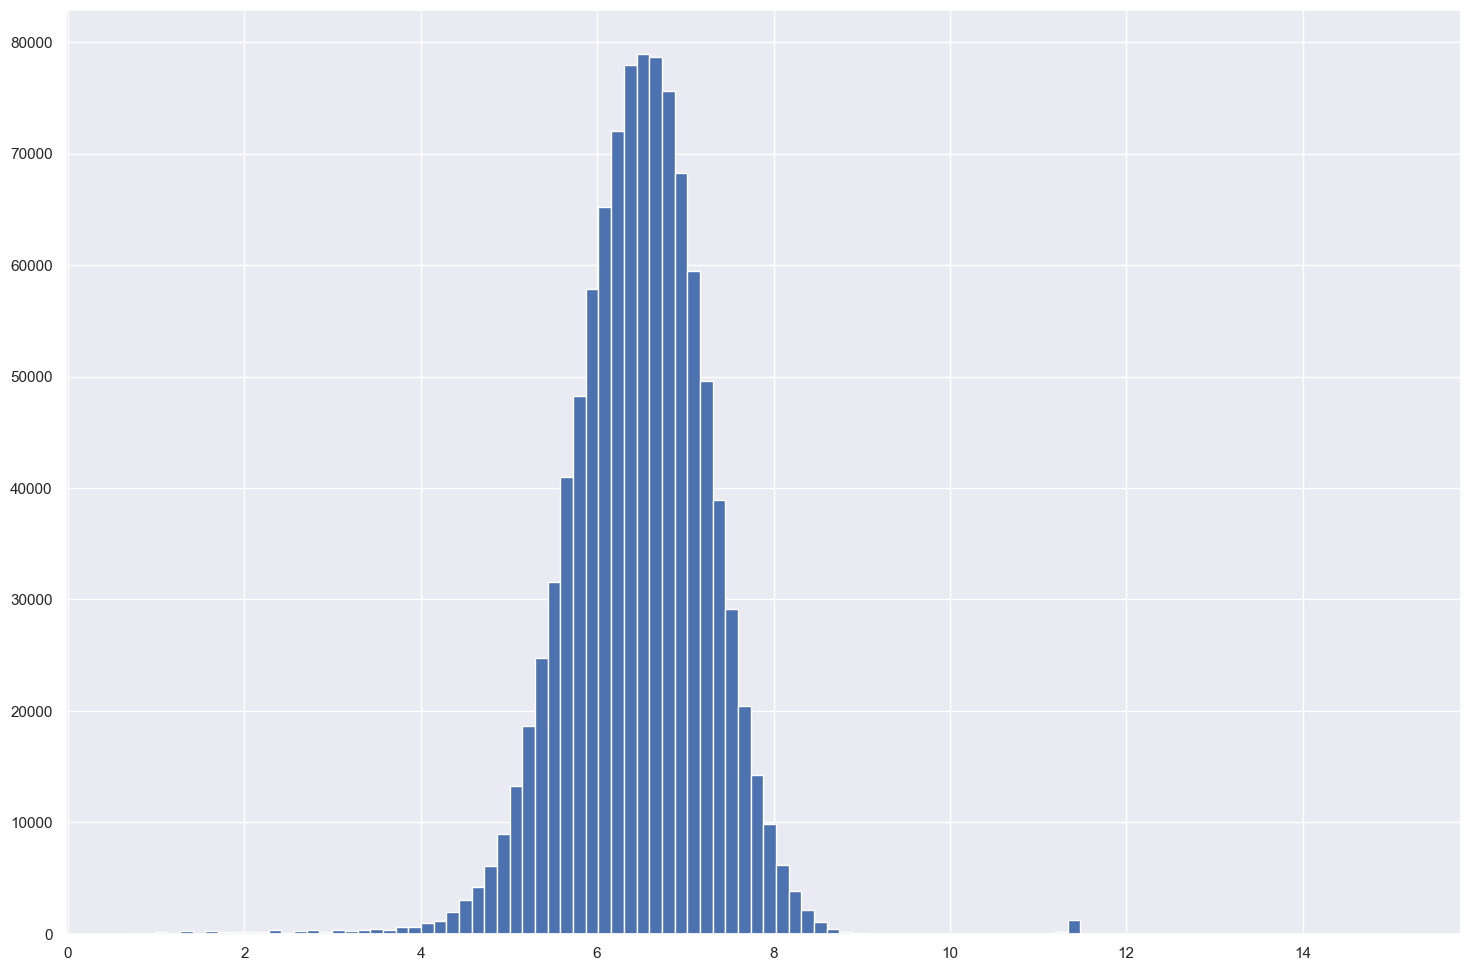

In [58]:
X_train['log_trip_duration'].hist(bins = 100)
plt.show()

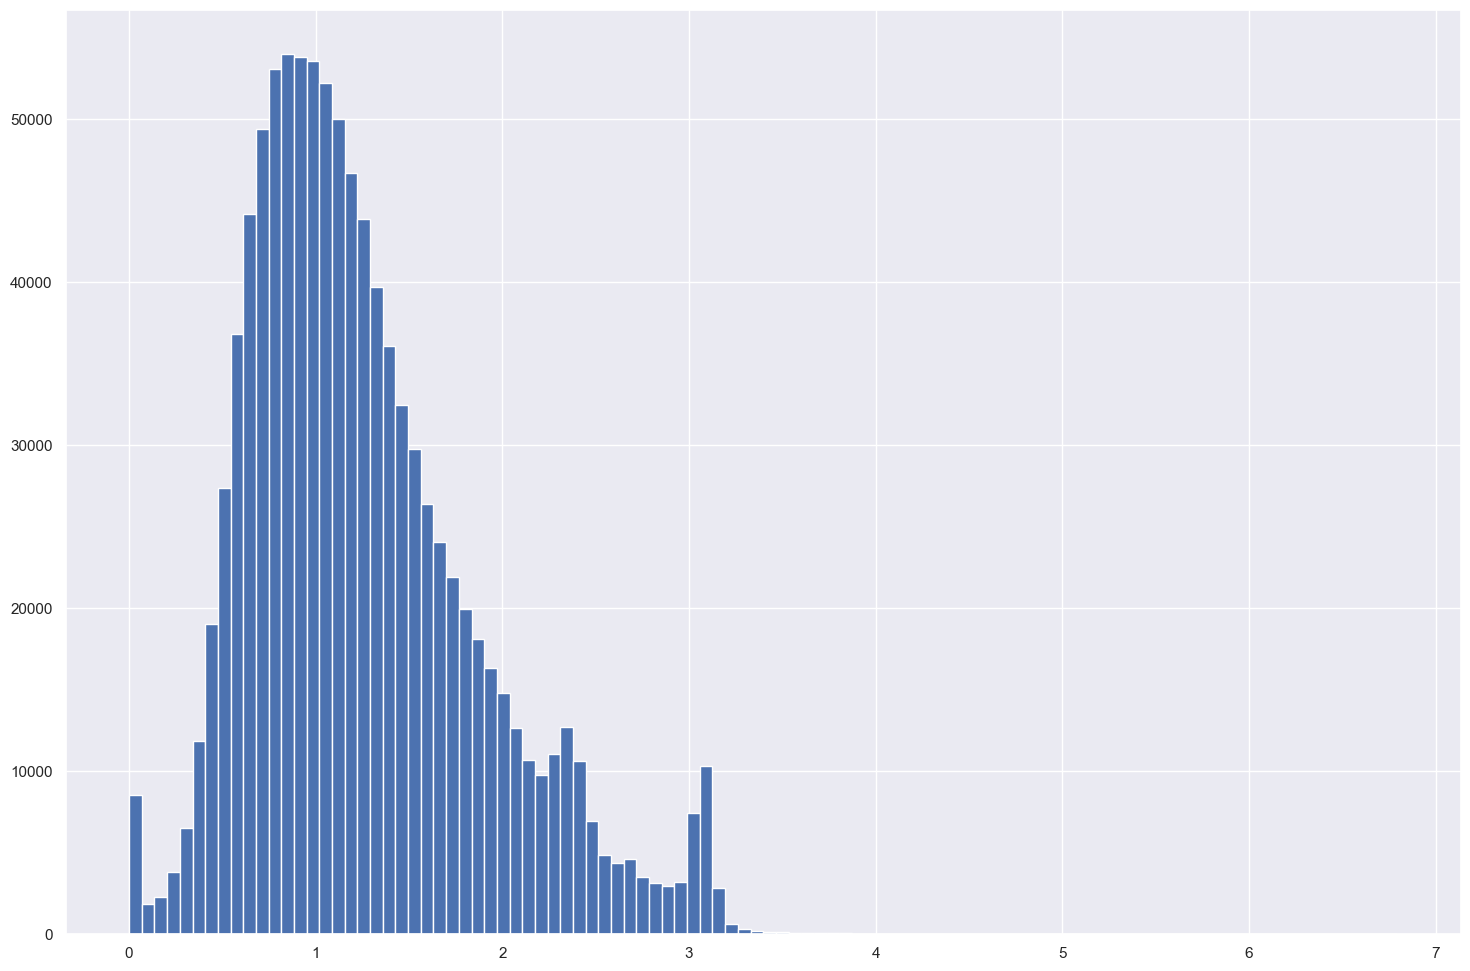

In [59]:
X_train['log_haversine'].hist(bins = 100)
plt.show()

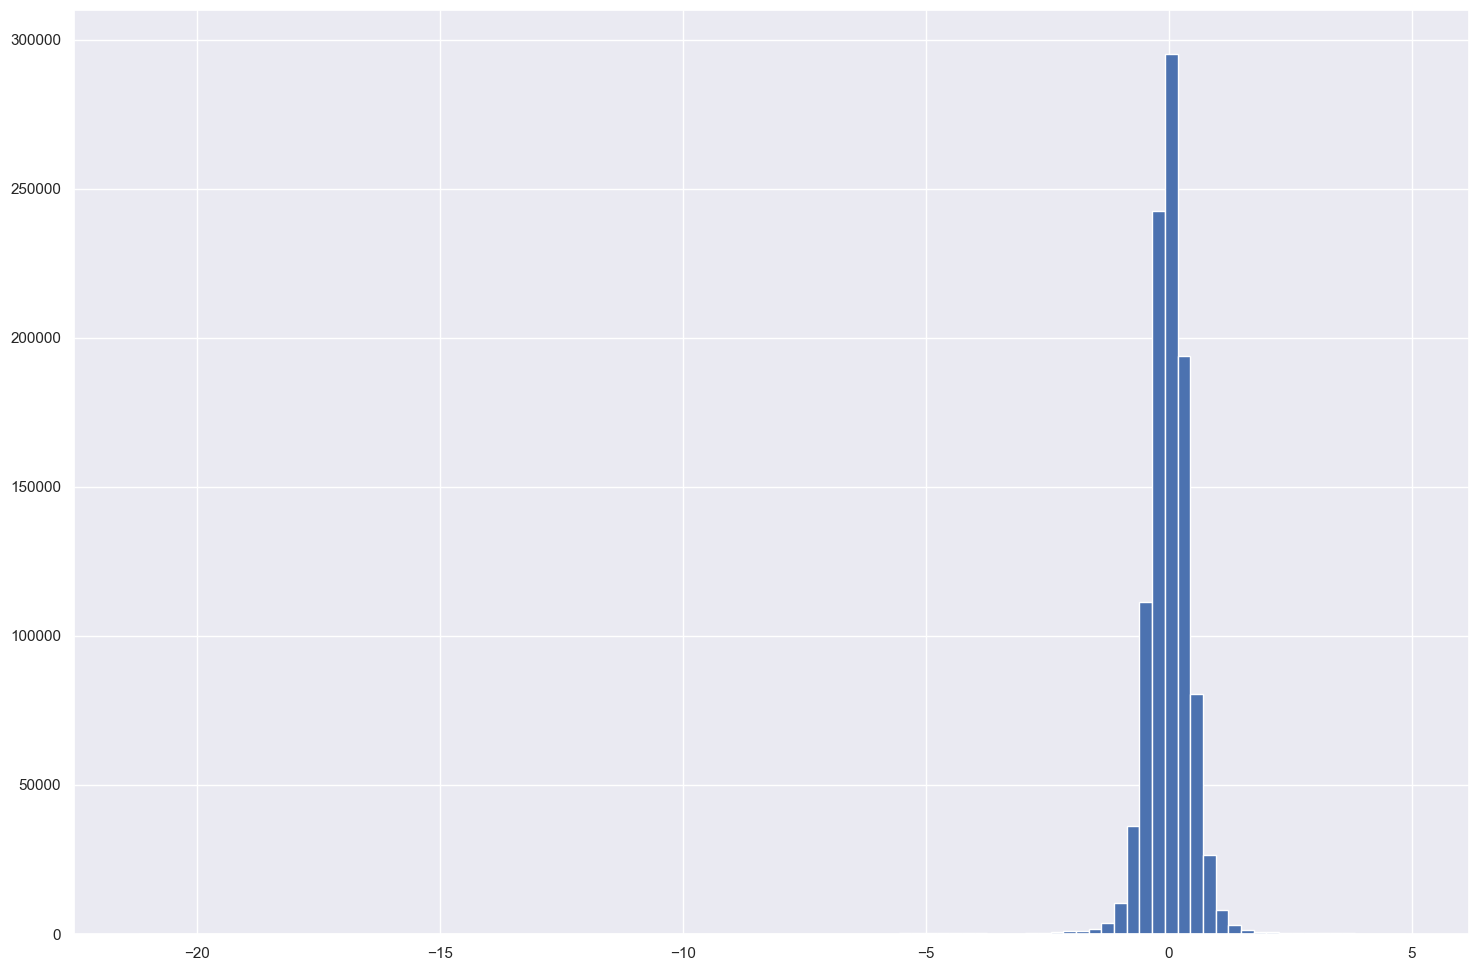

In [60]:
X_train['predict'] = model.predict(X_train)
(X_train['predict']-X_train['log_trip_duration']).hist(bins = 100)
plt.show()

In [61]:
X_train = X_train[X_train['log_trip_duration']>2]

In [62]:
X_train = X_train[X_train['log_haversine']<4]

In [63]:
X_train = X_train[abs(X_train['predict']-X_train['log_trip_duration'])<2]

In [64]:
train_size = X_train.shape[0]
y_train = X_train['log_trip_duration']
X = pd.concat([X_train, X_test])

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие). 

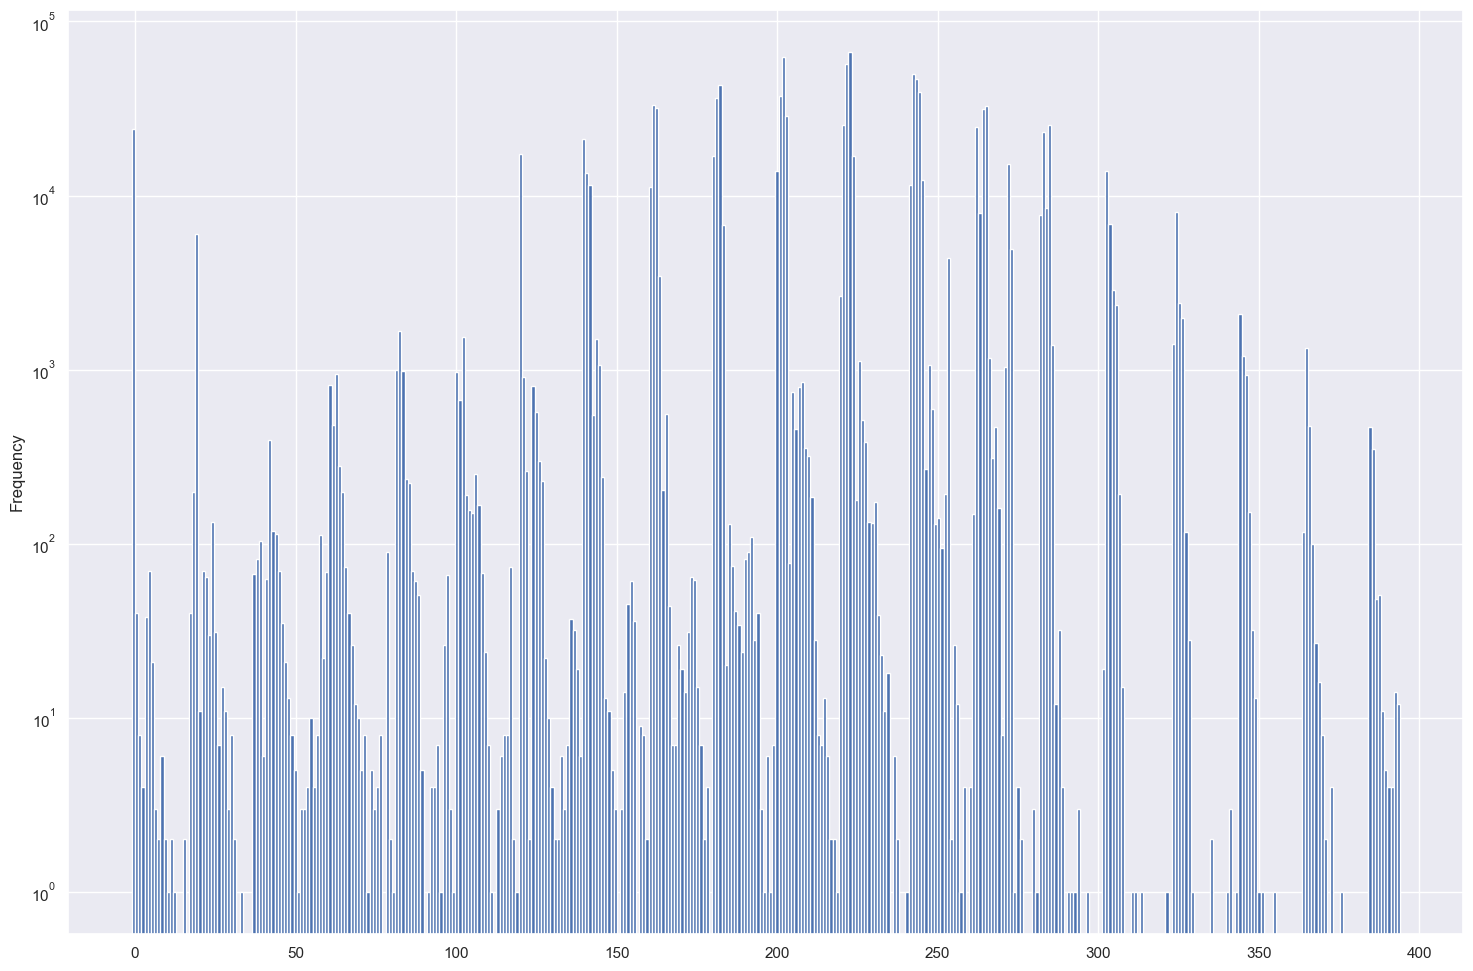

In [65]:
X_train['pick_cell'].plot(kind='hist', logy=True, bins = rows*cols)
plt.show()

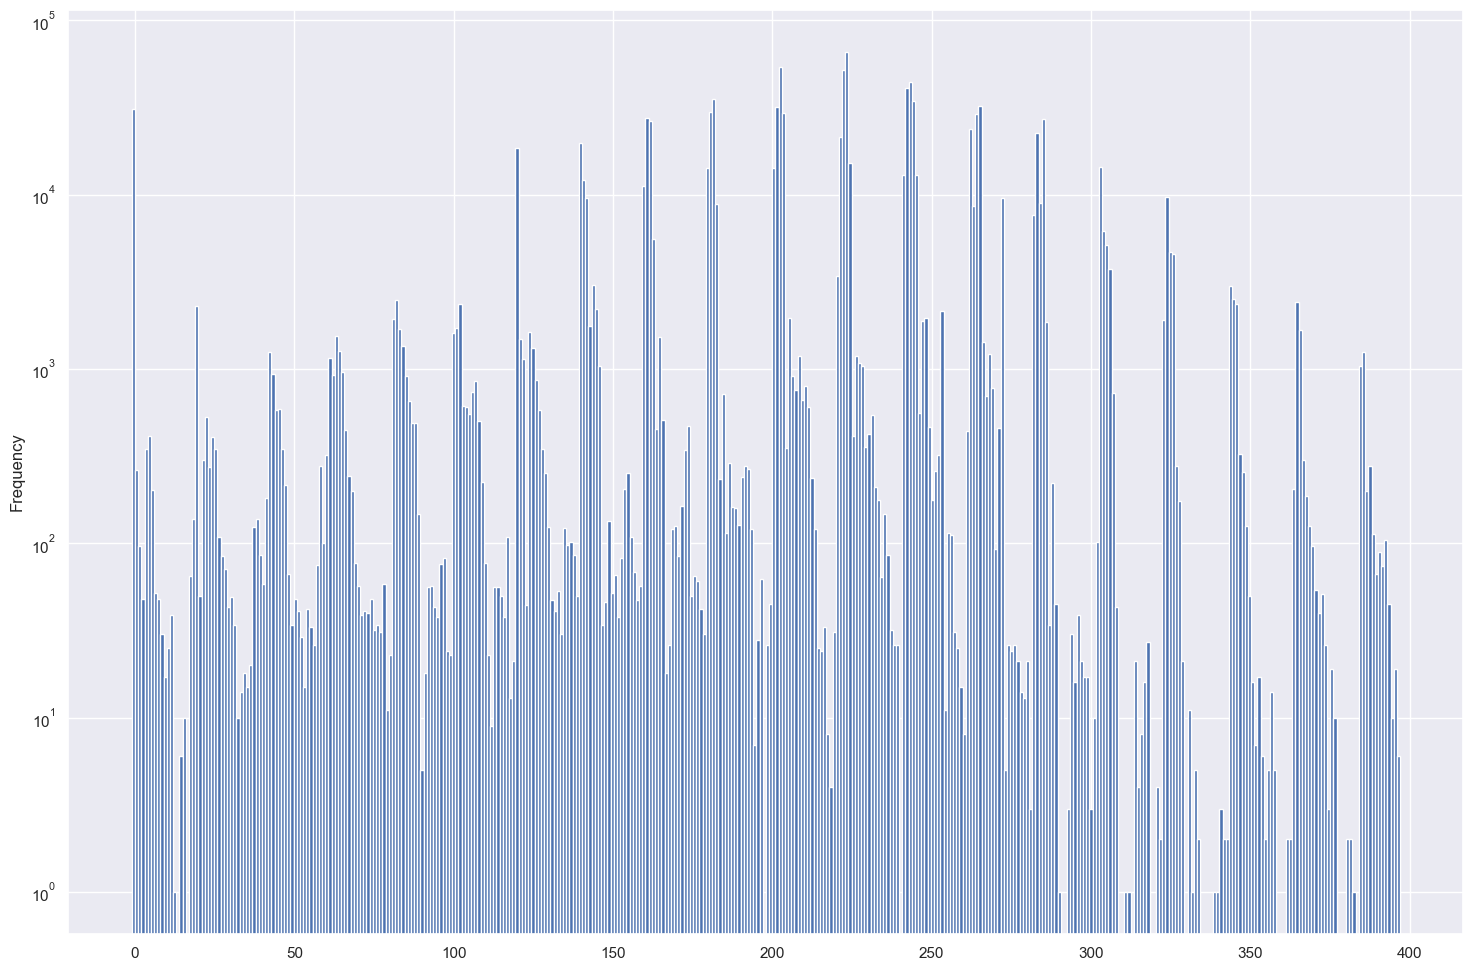

In [66]:
X_train['drop_cell'].plot(kind='hist', logy=True, bins = rows*cols)
plt.show()

In [67]:
pick_stats = X_train.groupby('pick_cell').count().reset_index()[['id', 'pick_cell']]
drop_stats = X_train.groupby('drop_cell').count().reset_index()[['id', 'drop_cell']]
pick_cells = set(pick_stats[pick_stats['id']>500]['pick_cell'])
drop_cells = set(drop_stats[drop_stats['id']>500]['drop_cell'])

In [68]:
X.loc[~X['pick_cell'].isin(pick_cells), 'pick_cell'] = -2
X.loc[~X['drop_cell'].isin(drop_cells), 'drop_cell'] = -2

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [78]:
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

In [82]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4818


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [71]:
print("до кодирования:", len(categorical))

до кодирования: 13


In [72]:
one_hot = pd.get_dummies(X, columns = categorical)
print("после кодирования:", one_hot.shape[1])

после кодирования: 257


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [73]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = pipeline.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.7959


Метод Ridge очевидно показывает результат лучше

Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [74]:
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

In [75]:
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=7)

In [77]:
lambdas = np.logspace(-2, 2, 50)
RMSE = []
ct = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown="ignore"), categorical), ('scaling', StandardScaler(), numeric)])

X_train_scaled = ct.fit_transform(X_train1[features])
X_val_scaled = ct.transform(X_val[features])

for i, lam in enumerate(lambdas):
    model = Ridge(lam)
    model.fit(X_train_scaled, y_train1)
    y_pred = model.predict(X_val_scaled)

    error = mean_squared_error(y_val, y_pred, squared=False)
    RMSE.append(error)

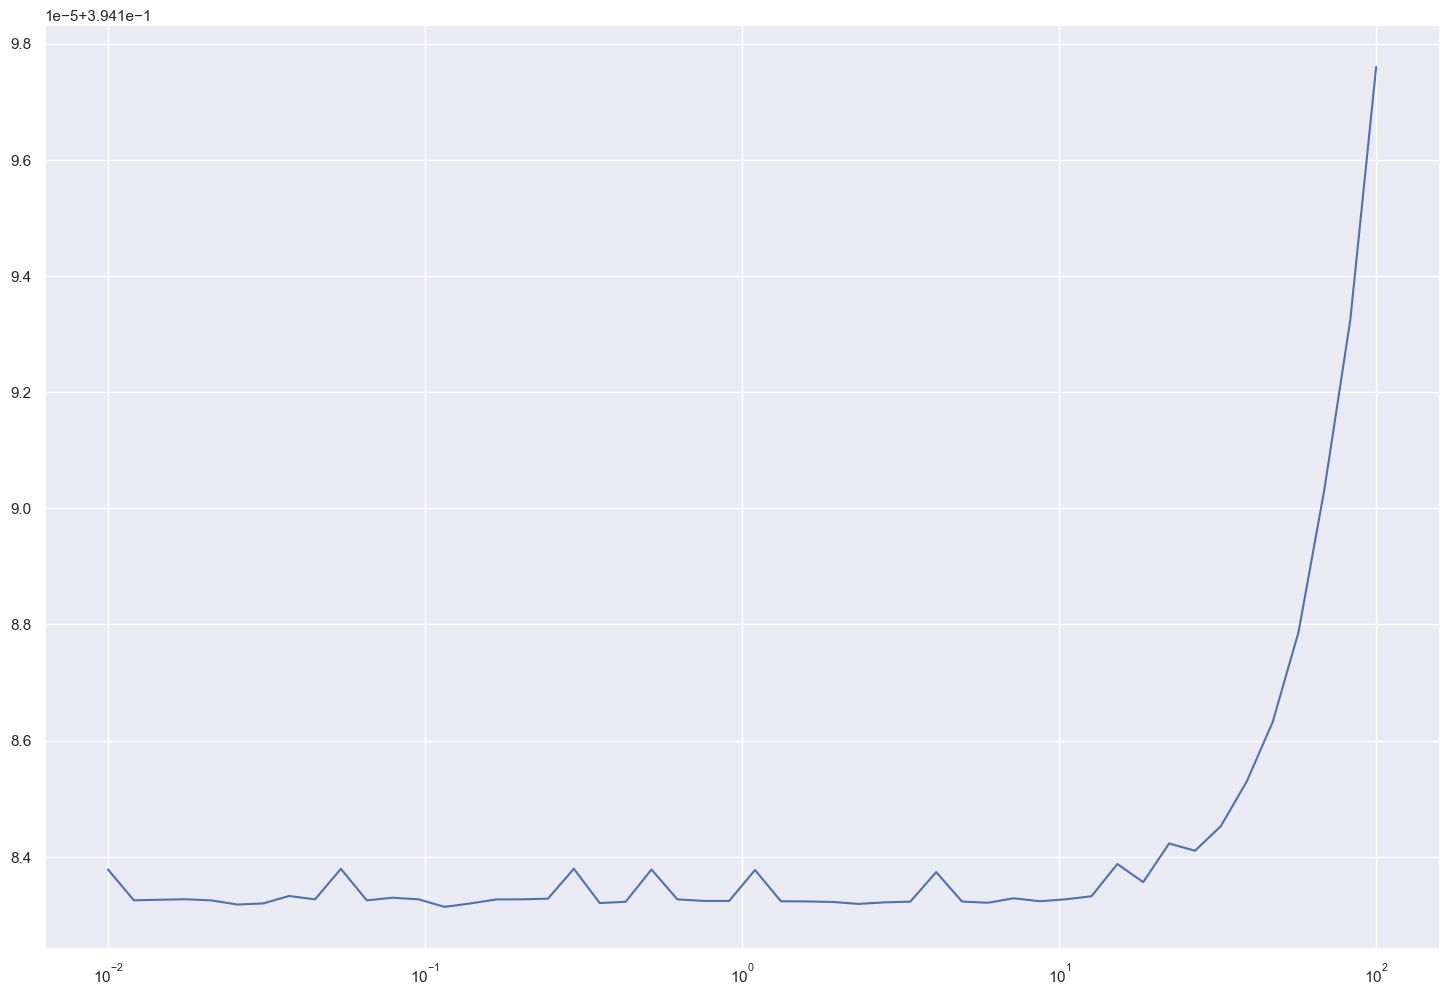

In [78]:
plt.semilogx(lambdas, RMSE)
plt.show()

In [79]:
best_alpha_ridge = lambdas[RMSE.index(min(RMSE))]
best_alpha_ridge

0.1151395399326447

In [80]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])

model = pipeline.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4800


Качество почти не улучшилось

In [77]:
lambdas = np.logspace(-3, 3, 10)
lasso_zeros = []
RMSE = []
ct = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown="ignore"), categorical), ('scaling', StandardScaler(), numeric)])

X_train_scaled = ct.fit_transform(X_train1[features])
X_val_scaled = ct.transform(X_val[features])

for i, lam in enumerate(lambdas):
    model = Lasso(lam)
    model.fit(X_train_scaled, y_train1)
    y_pred = model.predict(X_val_scaled)

    error = mean_squared_error(y_val, y_pred, squared=False)
    zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
    print(error)
    lasso_zeros.append(zeros)
    RMSE.append(error)

0.40268121350810254
0.4267253812752982
0.4537110325757576
0.47546454268824867
0.65689789314221
0.7480994444318556
0.7480994444318556
0.7480994444318556
0.7480994444318556
0.7480994444318556


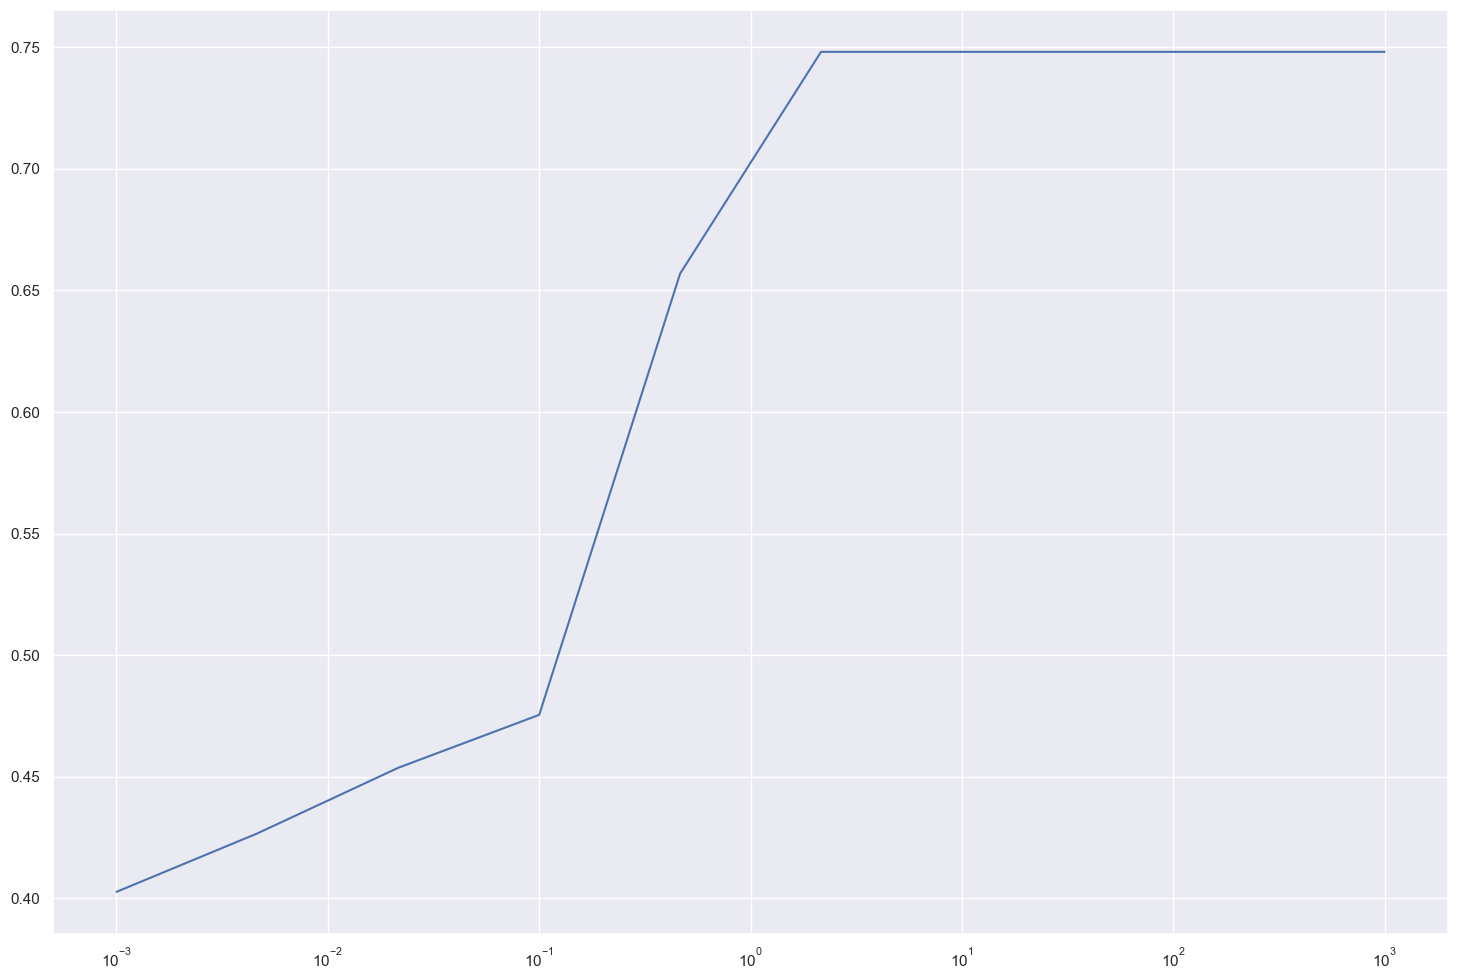

In [78]:
plt.semilogx(lambdas, RMSE)
plt.show()

In [80]:
best_alpha_lasso = lambdas[RMSE.index(min(RMSE))]
best_alpha_lasso

0.001

In [81]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha_lasso))
])

model = pipeline.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4894


Качество сильно выросло

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

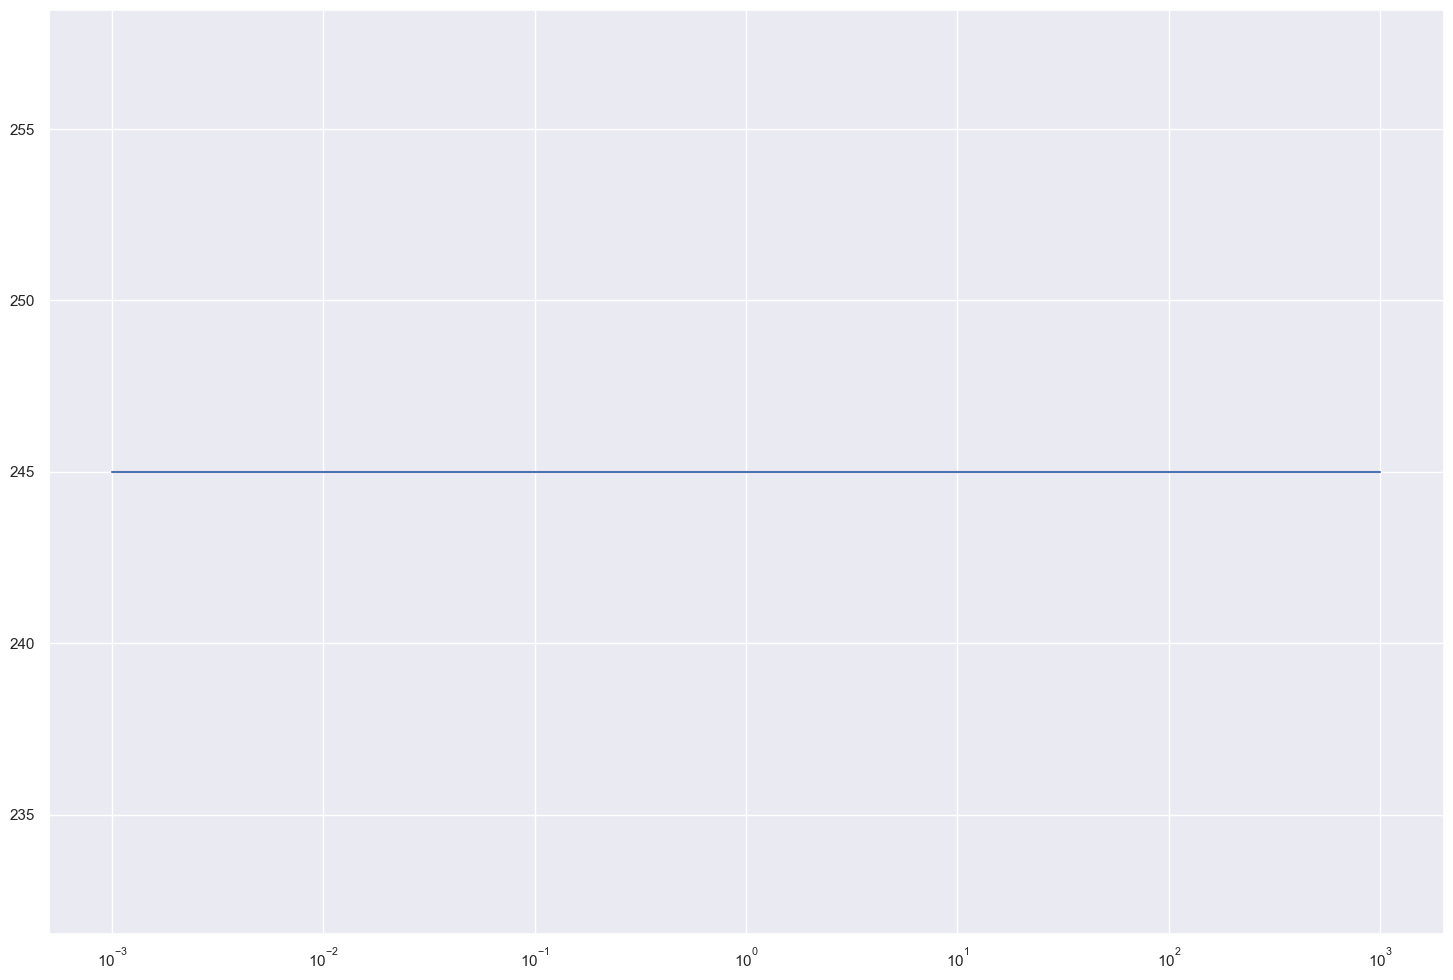

In [82]:
plt.semilogx(lambdas, lasso_zeros)
plt.show()

При перебранных гиперпараметрах, число нулевых весов не меняется.

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [83]:
X['route'] = X['pick_cell']*rows*cols + X['drop_cell']

routes = X[['route', 'id']]
routes = routes.groupby('route').count().reset_index()
routes = routes.sort_values(by = ['id'], ascending = False)
popular_routes = routes.iloc[:100]['route'].tolist()

In [84]:
X['route_pair'] = -1
for route in popular_routes:
    X.loc[X['route']==route, 'route_pair'] = route
X = X.drop(columns=['route'])

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [85]:
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

In [86]:
categorical.append('route_pair')
features = numeric+categorical

In [87]:
X_test.shape, y_test.shape

((437594, 29), (437594,))

In [88]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4737


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [92]:
min_latitude = min(X_train['pickup_latitude'].quantile(0.05), X_train['dropoff_latitude'].quantile(0.05))
max_latitude = max(X_train['pickup_latitude'].quantile(0.95), X_train['dropoff_latitude'].quantile(0.95))
min_longitude = min(X_train['pickup_longitude'].quantile(0.05), X_train['dropoff_longitude'].quantile(0.05))
max_longitude = max(X_train['pickup_longitude'].quantile(0.95), X_train['dropoff_longitude'].quantile(0.95))

location = ((min_latitude+max_latitude)/2, (min_longitude+max_longitude)/2)
m = folium.Map(location=location, zoom_start = 12)

In [94]:
x00 = -74.001290
x10 = -73.970157
y00 = 40.762124
y10 = 40.748953

folium.PolyLine(
    locations=[[y00, x00], [y10, x10]],
    color="#FF0000",
    weight=1,
).add_to(m)

x01 = -73.996413
x11 = -73.945139
y01 = 40.732212
y11 = 40.802543

folium.PolyLine(
    locations=[[y01, x01], [y11, x11]],
    color="#FF0000",
    weight=1,
).add_to(m)

vec1 = np.array([x10-x00, y10-y00])
vec1/=np.linalg.norm(vec1)
vec2 = np.array([x11-x01, y11-y01])
vec2/=np.linalg.norm(vec2)

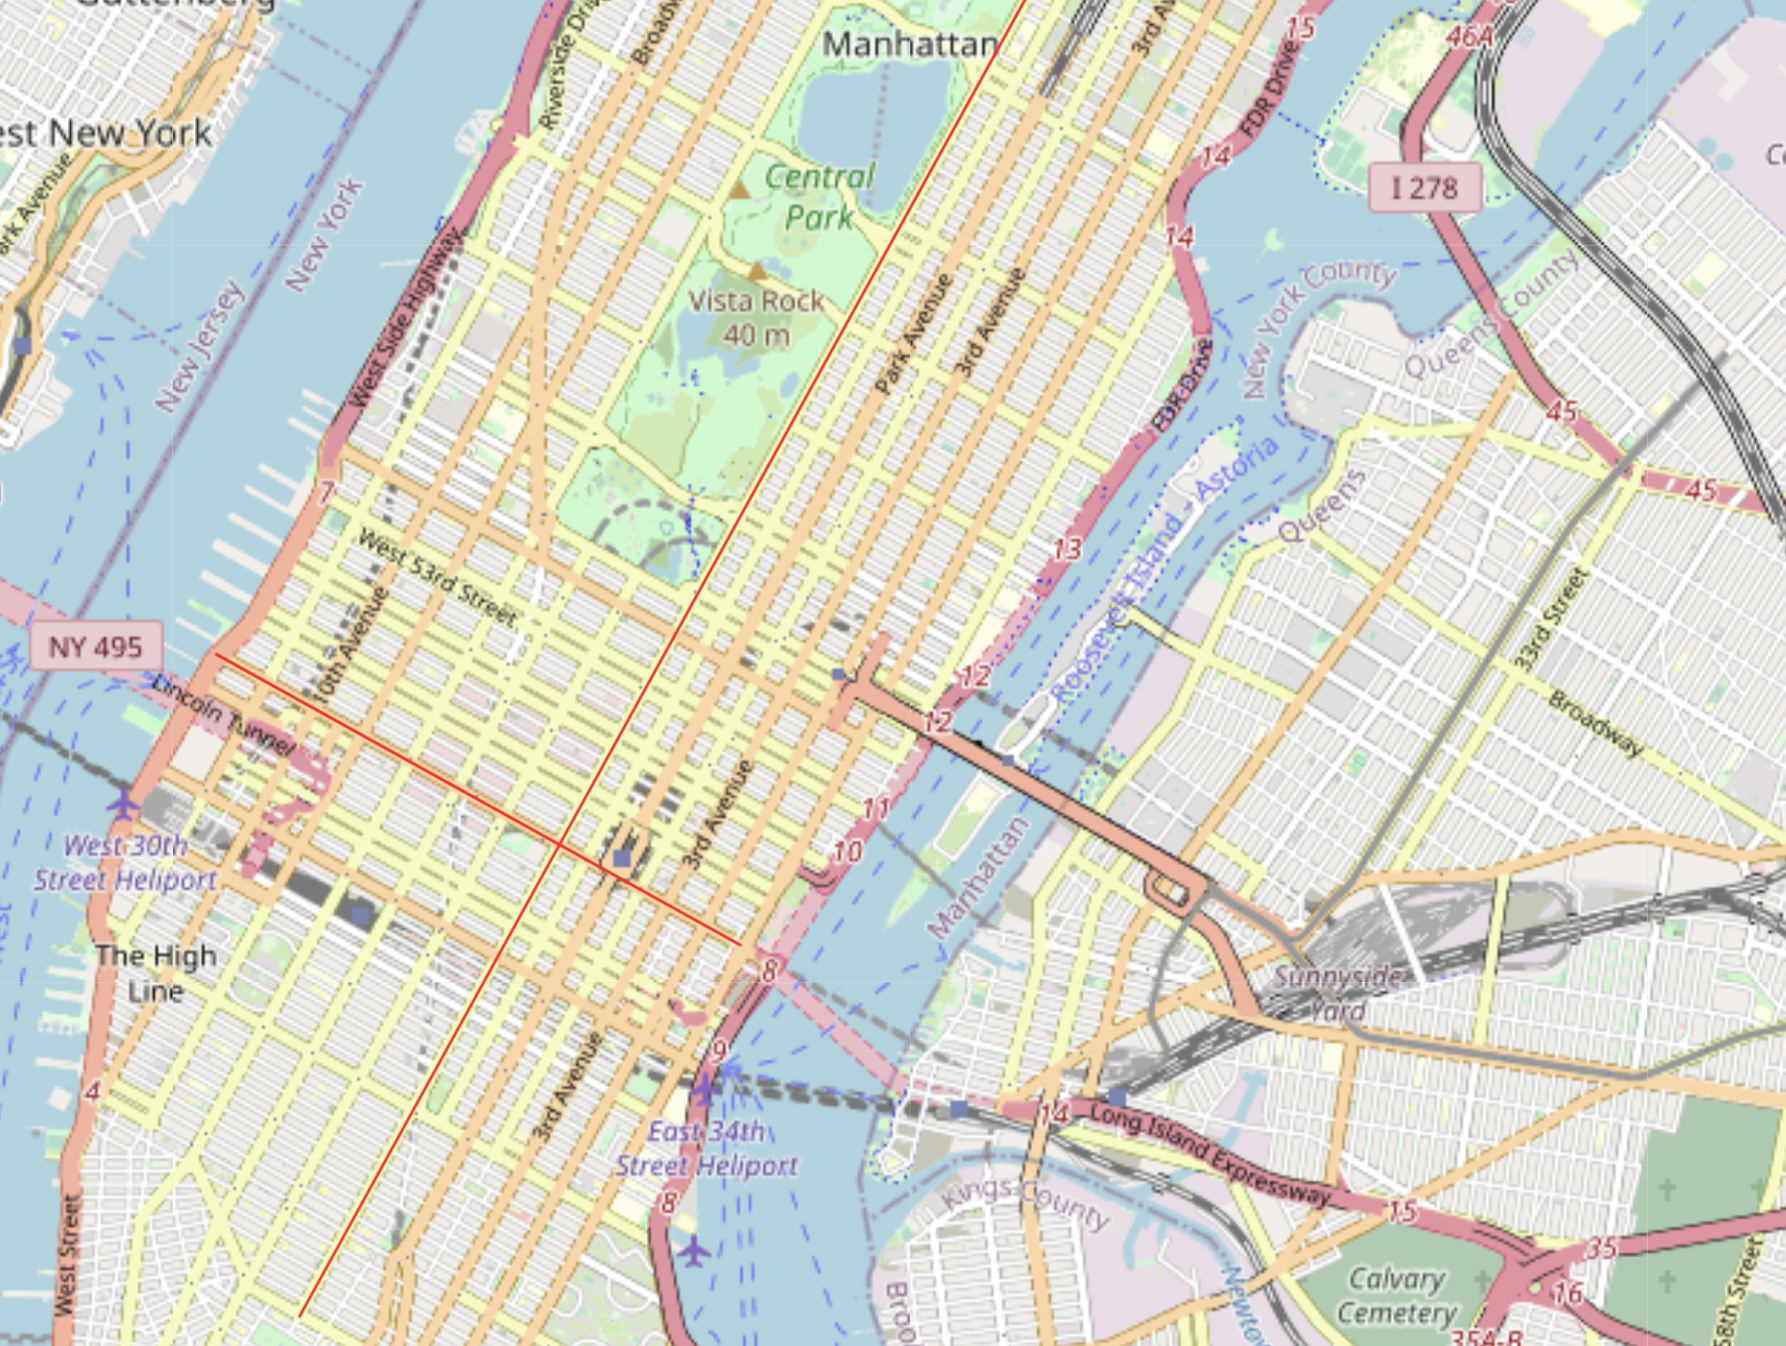

In [2]:
from IPython.display import Image
Image("pic.png")

In [95]:
def dist(lat1, lon1, lat2, lon2):
    l = vec1[0]*(lon2 - lon1) + vec1[1]*(lat2 - lat1)
    mid_lon = lon1 + l*vec1[0]
    mid_lat = lat1 + l*vec1[1]
    dist = vectorized_haversine(lat1, lon1, mid_lat, mid_lon)+vectorized_haversine(lat2, lon2, mid_lat, mid_lon)
    return dist

In [96]:
X['distance'] = dist(lat1=X['pickup_latitude'], lon1=X['pickup_longitude'], lat2=X['dropoff_latitude'], lon2=X['dropoff_longitude'])
X['log_distance'] = np.log1p(X['distance'])

In [97]:
X['distance'].corr(X['log_trip_duration'])

0.6231148945215661

In [98]:
X['log_distance'].corr(X['log_trip_duration'])

0.7791155078478635

In [99]:
X['log_haversine'].corr(X['log_trip_duration'])

0.7730297743417983

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [100]:
numeric.remove('log_haversine')
numeric.remove('haversine')
numeric.extend(['log_distance'])

In [101]:
features = categorical + numeric

In [102]:
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

In [103]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4603


**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [128]:
import h3

Создадим признаки означающие из какого шестиуогльника выехали и в каой приехали

In [129]:
X['pick_hex'] = X.apply(lambda row: h3.latlng_to_cell(lat = row['pickup_latitude'], lng = row['pickup_longitude'], res = 11), axis=1)
X['drop_hex'] = X.apply(lambda row: h3.latlng_to_cell(lat = row['dropoff_latitude'], lng = row['dropoff_longitude'], res = 11), axis=1)

Создадим признак - расстояние в шестиугольниках

In [130]:
X['dist_hex'] = X.apply(lambda row: h3.grid_distance(h1 = row['pick_hex'], h2 = row['drop_hex']), axis=1)

In [131]:
X['log_dist_hex'] = np.log1p(X['dist_hex'])

In [132]:
X['log_dist_hex'].corr(X['log_trip_duration'])

0.7859525408424277

In [133]:
numeric.extend(['log_dist_hex'])

In [134]:
features = categorical + numeric
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

Создадим признак - пару начального и конечного шестиугольника

In [135]:
X['pick_hex'] = X.apply(lambda row: h3.latlng_to_cell(lat = row['pickup_latitude'], lng = row['pickup_longitude'], res = 7), axis=1)
X['drop_hex'] = X.apply(lambda row: h3.latlng_to_cell(lat = row['dropoff_latitude'], lng = row['dropoff_longitude'], res = 7), axis=1)

In [137]:
X['hex_route'] = X['pick_hex'] + X['drop_hex']

Создадим признаки означающие из какого шестиуогльника выехали и в какой приехали

In [138]:
X['pick_hex'] = X.apply(lambda row: h3.latlng_to_cell(lat = row['pickup_latitude'], lng = row['pickup_longitude'], res = 10), axis=1)
X['drop_hex'] = X.apply(lambda row: h3.latlng_to_cell(lat = row['dropoff_latitude'], lng = row['dropoff_longitude'], res = 10), axis=1)

In [139]:
categorical = ['pickup_weekday',
 'is_abnormal_1',
 'is_abnormal_2',
 'pickup_month',
 'pickup_hour',
 'in_jam',
 'in_free',
 'from_LaGuardia',
 'to_LaGuardia',
 'from_Kennedy',
 'to_Kennedy',
 'route_pair',
 'pick_hex',
 'drop_hex',
 'hex_route']

In [140]:
numeric = ['pickup_day', 'log_dist_hex', 'log_distance']

In [141]:
features = categorical + numeric
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

In [142]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4375


Ниже подтверждение, что лосс правда упал

<img src="pic1.png" alt="MarineGEO circle logo" style="height: 100; width:100;"/>